# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

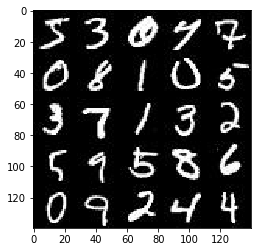

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

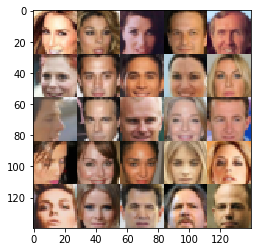

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "E:\\Anaconda\\envs\\tensorflow-gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "E:\\Anaconda\\envs\\tensorflow-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "E:\\Anaconda\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "E:\\Anaconda\\envs\\tensorflow-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "E:\\Anaconda\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "E:\\Anaconda\\envs\\tensorflow-gpu\\li

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:
def discriminator(images, reuse=False, training=True, alpha=.15):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Xavier: initializing the weights in the network by drawing them from a distribution with zero mean 
    #and a specific variance Var(W)= 1/nin where W is the initialization distribution for the neuron in questino
    # and nin is the number of neurons feeding into it. The distribution used is typically Gaussian or uniform. 
    
    kern = tf.contrib.layers.xavier_initializer()
    #kern = tf.random_normal_initializer(stddev = 0.02)
    with tf.variable_scope('discriminator', reuse=reuse): 
        #Input: 28x28x3 
        #NoteToSelf: No batch normalization on first layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kern, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=kern, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=training)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=kern, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=training)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #dropout = tf.nn.dropout(relu3, 0.7)
        #4x4x256
        #x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, kernel_initializer=kern, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=training)
        #relu4 = tf.maximum(alpha * bn4, bn4)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1) 
        out = tf.sigmoid(logits)
 
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True, alpha=.15):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #kern = kernel_initializer=tf.truncated_normal_initializer(stddev=0.02)
    kern = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('generator', reuse=not is_train):
        ## NOTE FOR FUTURE TEST
        # NoteToSelf: if padding='valid' does not work in first layer, try resizing first fully connected layer to 7x7x256 
        # and resize everything else accordingly.
        
        #first fully connected layer
        x1 = tf.layers.dense(z, 2*2*512, kernel_initializer = kern)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #2x2x512 now
        #convolutional layer #1
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, kernel_initializer = kern, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x128 now
        #convolutional layer #2
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, kernel_initializer = kern, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28x28x64 now
        #x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides = 2, kernel_initializer = kern, padding = 'same')
        #x4 = tf.layers.batch_normalization(x4, training = is_train)
        #x4 = tf.maximum(alpha * x4, x4)
        #output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, kernel_initializer = kern, padding='same') 
        '''
        x1 = tf.layers.dense(z, 7*7*256, kernel_initializer = kern) 
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x256
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, kernel_initializer = kern, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14x14x128
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, kernel_initializer = kern, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3) 
        #28x28x64
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides = 1, kernel_initializer = kern, padding = 'same')
        ''' 
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim, alpha=.15):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    #One-sided label smoothing 
    #https://github.com/aleju/papers/blob/master/neural-nets/Improved_Techniques_for_Training_GANs.md
    #Usually one would use the labels 0 (image is real) and 1 (image is fake).
    #Using smoother labels (0.1 and 0.9) seems to make networks more resistent to adversarial examples.
    #So they smooth the labels of fake images (apparently to 0.9?).
    #Smoothing the labels of real images would lead to (mathematical) problems in some cases, so they keep these at 0.
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    smoothed = tf.ones_like(d_model_real) * 0.9
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=smoothed))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, 
          beta1, get_batches, data_shape, data_image_mode, 
         print_every=100, show_every=1000, alpha=.15):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #Build the model (refer to lesson DCGAN) 
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = [] 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #ref: https://discussions.udacity.com/t/all-tests-passed-but-generator-loss-is-not-improving/248040/5
                batch_images *= 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
            
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode) 
                    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5725... Generator Loss: 1.6457
Epoch 1/2... Discriminator Loss: 0.3891... Generator Loss: 3.7856
Epoch 1/2... Discriminator Loss: 0.5363... Generator Loss: 2.6307
Epoch 1/2... Discriminator Loss: 0.4237... Generator Loss: 10.6675
Epoch 1/2... Discriminator Loss: 1.9325... Generator Loss: 0.2524
Epoch 1/2... Discriminator Loss: 0.6505... Generator Loss: 1.7626
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 8.4852
Epoch 1/2... Discriminator Loss: 0.4392... Generator Loss: 4.5948
Epoch 1/2... Discriminator Loss: 1.5076... Generator Loss: 0.4335
Epoch 1/2... Discriminator Loss: 0.4549... Generator Loss: 4.4735


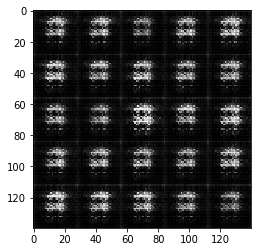

Epoch 1/2... Discriminator Loss: 0.8795... Generator Loss: 8.6973
Epoch 1/2... Discriminator Loss: 0.5951... Generator Loss: 2.1911
Epoch 1/2... Discriminator Loss: 0.7047... Generator Loss: 2.1822
Epoch 1/2... Discriminator Loss: 0.4887... Generator Loss: 3.0076
Epoch 1/2... Discriminator Loss: 0.4169... Generator Loss: 4.0593
Epoch 1/2... Discriminator Loss: 0.3985... Generator Loss: 3.6829
Epoch 1/2... Discriminator Loss: 0.4123... Generator Loss: 3.9658
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.3427
Epoch 1/2... Discriminator Loss: 0.4047... Generator Loss: 4.3913
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 3.2823


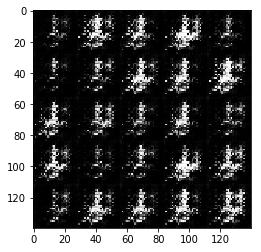

Epoch 1/2... Discriminator Loss: 0.3998... Generator Loss: 3.3836
Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 3.3887
Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 3.2020
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 3.3321
Epoch 1/2... Discriminator Loss: 0.3920... Generator Loss: 3.7592
Epoch 1/2... Discriminator Loss: 0.3687... Generator Loss: 5.4371
Epoch 1/2... Discriminator Loss: 0.3980... Generator Loss: 3.6903
Epoch 1/2... Discriminator Loss: 0.3990... Generator Loss: 3.9389
Epoch 1/2... Discriminator Loss: 0.4211... Generator Loss: 3.2715
Epoch 1/2... Discriminator Loss: 0.5574... Generator Loss: 1.8311


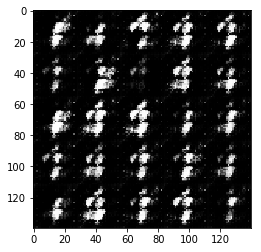

Epoch 1/2... Discriminator Loss: 0.4237... Generator Loss: 3.3990
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 1.3822
Epoch 1/2... Discriminator Loss: 0.5595... Generator Loss: 3.7473
Epoch 1/2... Discriminator Loss: 0.5341... Generator Loss: 2.3219
Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 4.1435
Epoch 1/2... Discriminator Loss: 0.4915... Generator Loss: 2.5587
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 3.1379
Epoch 1/2... Discriminator Loss: 0.4400... Generator Loss: 3.9779
Epoch 1/2... Discriminator Loss: 0.4066... Generator Loss: 3.9676
Epoch 1/2... Discriminator Loss: 0.4610... Generator Loss: 3.3831


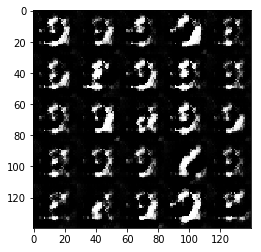

Epoch 1/2... Discriminator Loss: 0.4673... Generator Loss: 2.8484
Epoch 1/2... Discriminator Loss: 0.3987... Generator Loss: 4.0232
Epoch 1/2... Discriminator Loss: 0.4054... Generator Loss: 4.1389
Epoch 1/2... Discriminator Loss: 0.5429... Generator Loss: 2.2241
Epoch 1/2... Discriminator Loss: 0.4509... Generator Loss: 3.6269
Epoch 1/2... Discriminator Loss: 0.5377... Generator Loss: 2.3303
Epoch 1/2... Discriminator Loss: 0.4596... Generator Loss: 3.1187
Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 3.4839
Epoch 1/2... Discriminator Loss: 0.4862... Generator Loss: 2.9742
Epoch 1/2... Discriminator Loss: 0.4817... Generator Loss: 2.5618


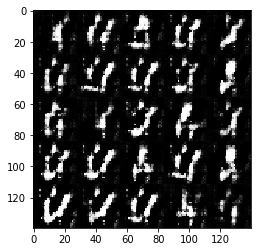

Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 5.5655
Epoch 1/2... Discriminator Loss: 0.5259... Generator Loss: 2.7378
Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 2.6961
Epoch 1/2... Discriminator Loss: 0.4380... Generator Loss: 2.8662
Epoch 1/2... Discriminator Loss: 1.0241... Generator Loss: 5.7477
Epoch 1/2... Discriminator Loss: 0.7699... Generator Loss: 1.8548
Epoch 1/2... Discriminator Loss: 0.6105... Generator Loss: 2.1421
Epoch 1/2... Discriminator Loss: 0.5155... Generator Loss: 2.9692
Epoch 1/2... Discriminator Loss: 0.5193... Generator Loss: 2.6153
Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 1.3637


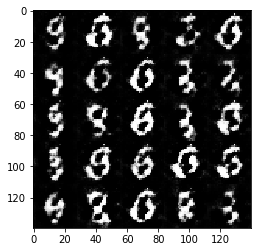

Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 2.1241
Epoch 1/2... Discriminator Loss: 0.5927... Generator Loss: 2.0741
Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 2.2805
Epoch 1/2... Discriminator Loss: 0.6237... Generator Loss: 2.0683
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 2.3731
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 2.1757
Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 3.1489
Epoch 1/2... Discriminator Loss: 0.6785... Generator Loss: 3.5495
Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 2.7092
Epoch 1/2... Discriminator Loss: 0.7475... Generator Loss: 1.5479


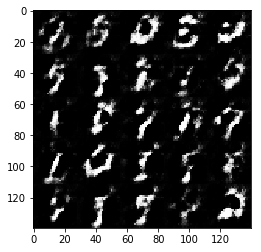

Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.0492
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 2.9366
Epoch 1/2... Discriminator Loss: 0.6303... Generator Loss: 1.6793
Epoch 1/2... Discriminator Loss: 0.6717... Generator Loss: 2.1839
Epoch 1/2... Discriminator Loss: 0.7743... Generator Loss: 3.5254
Epoch 1/2... Discriminator Loss: 0.5946... Generator Loss: 2.5940
Epoch 1/2... Discriminator Loss: 0.7751... Generator Loss: 2.8482
Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 1.2548
Epoch 1/2... Discriminator Loss: 0.7641... Generator Loss: 1.5543
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 1.0694


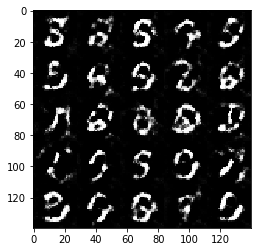

Epoch 1/2... Discriminator Loss: 0.6649... Generator Loss: 2.2844
Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 1.1864
Epoch 1/2... Discriminator Loss: 0.6769... Generator Loss: 2.0270
Epoch 1/2... Discriminator Loss: 0.7040... Generator Loss: 1.6806
Epoch 1/2... Discriminator Loss: 0.7959... Generator Loss: 1.7403
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 1.4911
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.0262
Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 1.3866
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.7616
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.8422


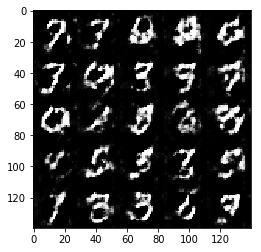

Epoch 1/2... Discriminator Loss: 0.5846... Generator Loss: 2.3466
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 1.2324
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 2.0230
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.1624
Epoch 1/2... Discriminator Loss: 0.7298... Generator Loss: 1.6616
Epoch 1/2... Discriminator Loss: 0.7865... Generator Loss: 1.5430
Epoch 1/2... Discriminator Loss: 0.6723... Generator Loss: 1.7187
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 2.2175
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 1.4204
Epoch 1/2... Discriminator Loss: 0.7462... Generator Loss: 1.4783


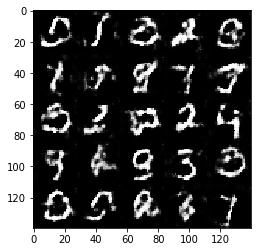

Epoch 1/2... Discriminator Loss: 0.7109... Generator Loss: 2.1445
Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 2.0546
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.2526
Epoch 1/2... Discriminator Loss: 0.7246... Generator Loss: 2.2545
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 1.7591
Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 1.8147
Epoch 1/2... Discriminator Loss: 0.6159... Generator Loss: 1.7462
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 2.4030
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 1.3065


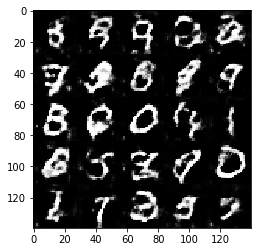

Epoch 1/2... Discriminator Loss: 0.6939... Generator Loss: 2.0009
Epoch 1/2... Discriminator Loss: 0.7262... Generator Loss: 1.9470
Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 2.0448
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 2.1695
Epoch 1/2... Discriminator Loss: 0.6862... Generator Loss: 1.8407
Epoch 1/2... Discriminator Loss: 0.6659... Generator Loss: 2.5582
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 1.3088
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.4720
Epoch 1/2... Discriminator Loss: 0.7404... Generator Loss: 1.6910
Epoch 1/2... Discriminator Loss: 0.6708... Generator Loss: 2.2636


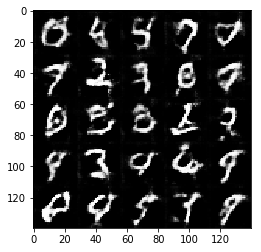

Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.1209
Epoch 1/2... Discriminator Loss: 0.8154... Generator Loss: 1.6625
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 1.2772
Epoch 1/2... Discriminator Loss: 0.8316... Generator Loss: 1.4472
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.6704
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 1.7316
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.4123
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.8971
Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 1.0490
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 1.2841


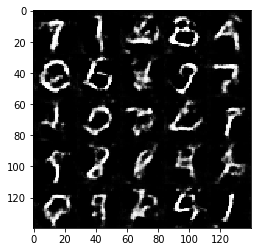

Epoch 1/2... Discriminator Loss: 0.7361... Generator Loss: 2.3857
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 1.4748
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 1.7107
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 0.8672
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 0.5420
Epoch 1/2... Discriminator Loss: 0.7817... Generator Loss: 1.1857
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.4050
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.6910
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 1.5634


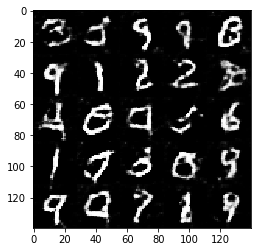

Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 2.5827
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.6581
Epoch 1/2... Discriminator Loss: 1.1097... Generator Loss: 2.4906
Epoch 1/2... Discriminator Loss: 0.7716... Generator Loss: 1.3859
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 1.8131
Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 1.1651
Epoch 1/2... Discriminator Loss: 0.9599... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 1.5618
Epoch 1/2... Discriminator Loss: 0.8691... Generator Loss: 1.1997
Epoch 1/2... Discriminator Loss: 0.7108... Generator Loss: 1.9917


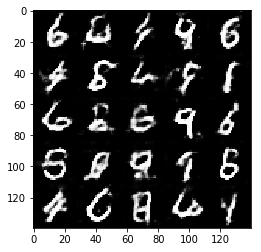

Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 1.4116
Epoch 1/2... Discriminator Loss: 0.7770... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 0.9548... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 1.8694
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 0.9598... Generator Loss: 1.0402
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 2.0705
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.1862
Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 1.4180
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.1987


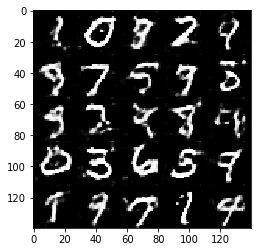

Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 1.7445
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 0.8135... Generator Loss: 1.4631
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 1.2627
Epoch 1/2... Discriminator Loss: 0.6381... Generator Loss: 2.0830
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 2.8708
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 0.6704... Generator Loss: 1.8267
Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 1.7531
Epoch 1/2... Discriminator Loss: 0.8030... Generator Loss: 1.4137


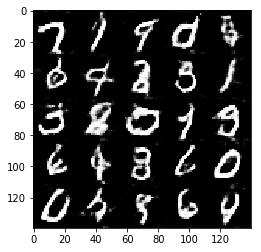

Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 1.4367
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 1.5848
Epoch 1/2... Discriminator Loss: 1.1163... Generator Loss: 1.0712
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 1.5989
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 1.2608
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.1864
Epoch 1/2... Discriminator Loss: 0.8374... Generator Loss: 1.1835
Epoch 1/2... Discriminator Loss: 0.6823... Generator Loss: 1.6146
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 1.9110
Epoch 1/2... Discriminator Loss: 0.6621... Generator Loss: 1.7521


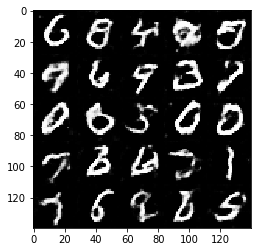

Epoch 1/2... Discriminator Loss: 0.8188... Generator Loss: 1.1473
Epoch 1/2... Discriminator Loss: 0.6840... Generator Loss: 1.6450
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 1.8399
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 1.7651
Epoch 1/2... Discriminator Loss: 0.7836... Generator Loss: 1.2325
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 1.3698
Epoch 2/2... Discriminator Loss: 0.6097... Generator Loss: 2.3330
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 0.9895
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.6023


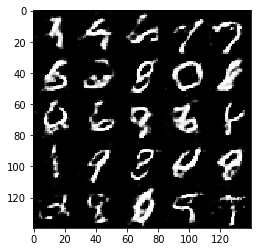

Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.6868
Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 1.2847
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 1.7467
Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 1.3438
Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.1375
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.4084
Epoch 2/2... Discriminator Loss: 1.6415... Generator Loss: 0.4357
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.6889
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.3130


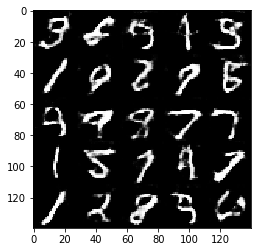

Epoch 2/2... Discriminator Loss: 0.9257... Generator Loss: 0.9937
Epoch 2/2... Discriminator Loss: 0.6507... Generator Loss: 1.6343
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.2351
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.3660
Epoch 2/2... Discriminator Loss: 0.7173... Generator Loss: 2.6120
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.3601
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 0.8904
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.7335


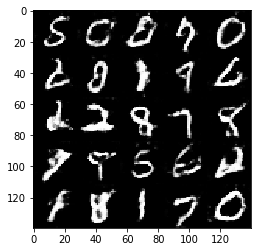

Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 1.3240
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 1.9496
Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.7031
Epoch 2/2... Discriminator Loss: 0.6723... Generator Loss: 1.5921
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.1153
Epoch 2/2... Discriminator Loss: 0.9268... Generator Loss: 2.4565
Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 0.9147
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.5568
Epoch 2/2... Discriminator Loss: 0.7515... Generator Loss: 1.3195
Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 1.0880


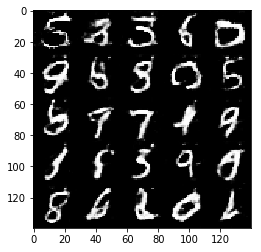

Epoch 2/2... Discriminator Loss: 0.7155... Generator Loss: 1.5389
Epoch 2/2... Discriminator Loss: 0.6722... Generator Loss: 1.5748
Epoch 2/2... Discriminator Loss: 0.8550... Generator Loss: 1.1224
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.0882
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.0286
Epoch 2/2... Discriminator Loss: 0.6752... Generator Loss: 1.5010
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.3108
Epoch 2/2... Discriminator Loss: 0.7344... Generator Loss: 1.3464
Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 1.1697


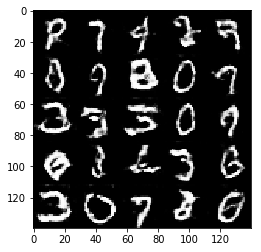

Epoch 2/2... Discriminator Loss: 0.7362... Generator Loss: 1.4354
Epoch 2/2... Discriminator Loss: 0.9772... Generator Loss: 0.9702
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 0.9205
Epoch 2/2... Discriminator Loss: 0.7321... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 0.8073... Generator Loss: 1.2081
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 1.8976
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.2742
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 1.3098


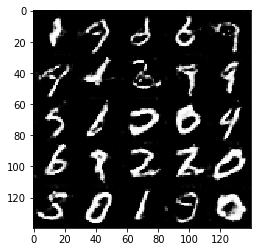

Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.4604
Epoch 2/2... Discriminator Loss: 0.6846... Generator Loss: 2.4817
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.5805
Epoch 2/2... Discriminator Loss: 1.6987... Generator Loss: 0.4255
Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 0.9746
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 0.6356... Generator Loss: 1.7538
Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 0.8719
Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 1.1882


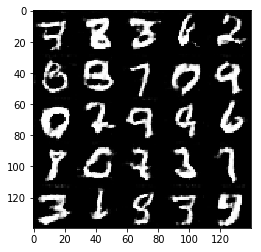

Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.9806
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.6665
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.1467
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.0211
Epoch 2/2... Discriminator Loss: 0.9490... Generator Loss: 0.9550
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.7479
Epoch 2/2... Discriminator Loss: 0.7847... Generator Loss: 1.3477
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 2.0227


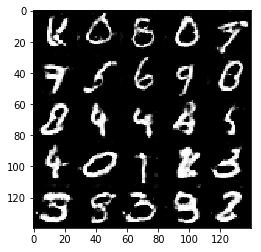

Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.4564
Epoch 2/2... Discriminator Loss: 0.5649... Generator Loss: 2.0929
Epoch 2/2... Discriminator Loss: 0.5630... Generator Loss: 1.9882
Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 1.1092
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 2.0106
Epoch 2/2... Discriminator Loss: 0.6067... Generator Loss: 2.0662
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 2.6305
Epoch 2/2... Discriminator Loss: 0.7097... Generator Loss: 1.4993
Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 1.5928


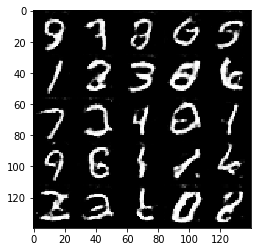

Epoch 2/2... Discriminator Loss: 0.6603... Generator Loss: 1.5053
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.9544
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.4076
Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.4517
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 1.3261
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 1.8403
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.7225
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 0.9051
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.2774


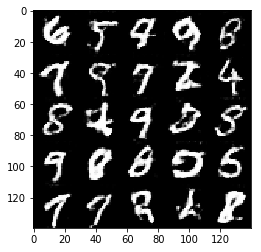

Epoch 2/2... Discriminator Loss: 0.7002... Generator Loss: 2.0328
Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 1.5315
Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 2.1214
Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 1.8904
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.6642
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 0.7424... Generator Loss: 1.5666
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 1.5671
Epoch 2/2... Discriminator Loss: 0.6184... Generator Loss: 1.6115
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.6547


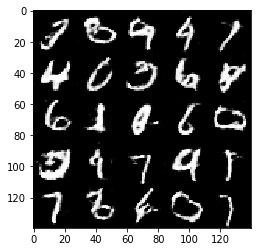

Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 1.7338
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.4473
Epoch 2/2... Discriminator Loss: 0.6264... Generator Loss: 1.9060
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.1536
Epoch 2/2... Discriminator Loss: 0.7469... Generator Loss: 1.2583
Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 1.4183
Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 3.0654
Epoch 2/2... Discriminator Loss: 0.6468... Generator Loss: 2.2504
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.0806
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 1.9363


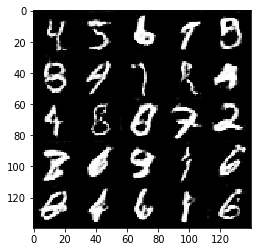

Epoch 2/2... Discriminator Loss: 0.7324... Generator Loss: 1.3872
Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 1.4348
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.3240
Epoch 2/2... Discriminator Loss: 0.8642... Generator Loss: 1.0679
Epoch 2/2... Discriminator Loss: 0.5698... Generator Loss: 1.8618
Epoch 2/2... Discriminator Loss: 0.6179... Generator Loss: 1.7963
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.3132
Epoch 2/2... Discriminator Loss: 0.8164... Generator Loss: 1.2602
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 0.8779
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 0.9493


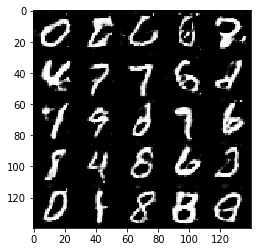

Epoch 2/2... Discriminator Loss: 0.5336... Generator Loss: 2.0576
Epoch 2/2... Discriminator Loss: 0.5492... Generator Loss: 1.9986
Epoch 2/2... Discriminator Loss: 0.7994... Generator Loss: 2.1859
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.7372
Epoch 2/2... Discriminator Loss: 1.7218... Generator Loss: 0.4164
Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 1.5152
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.7019
Epoch 2/2... Discriminator Loss: 0.7307... Generator Loss: 1.3979
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.3903
Epoch 2/2... Discriminator Loss: 0.6873... Generator Loss: 1.8023


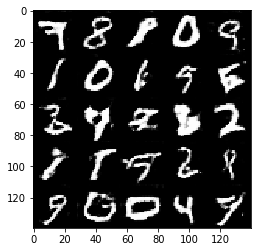

Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 1.7158
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.6820
Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.6330
Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 2.2426
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.2340
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 1.2888
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.1685
Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 1.4935
Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.9981
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 1.1723


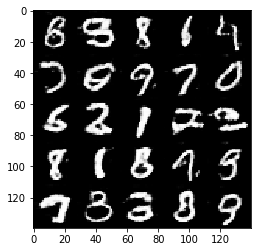

Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.7230
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 1.8938
Epoch 2/2... Discriminator Loss: 0.6852... Generator Loss: 1.8487
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 2.5331
Epoch 2/2... Discriminator Loss: 0.6444... Generator Loss: 1.9543
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 2.0787
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 0.8959
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.5298
Epoch 2/2... Discriminator Loss: 0.9447... Generator Loss: 0.9207


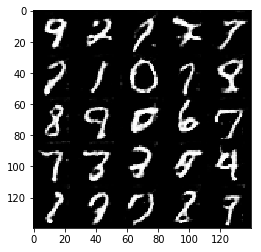

Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 1.2961
Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 2.6831
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 1.7467
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.8217
Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 0.7222
Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 2.0364
Epoch 2/2... Discriminator Loss: 0.4922... Generator Loss: 2.7651
Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 2.4227
Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 3.0710
Epoch 2/2... Discriminator Loss: 0.5509... Generator Loss: 2.3409


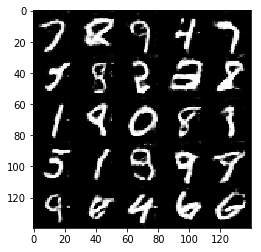

Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 0.9843
Epoch 2/2... Discriminator Loss: 0.7186... Generator Loss: 1.4685
Epoch 2/2... Discriminator Loss: 0.6681... Generator Loss: 1.5228
Epoch 2/2... Discriminator Loss: 0.6785... Generator Loss: 1.6266
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 0.9585
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 1.2915
Epoch 2/2... Discriminator Loss: 0.6616... Generator Loss: 1.6101
Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.3139
Epoch 2/2... Discriminator Loss: 1.9202... Generator Loss: 0.3695
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.6356


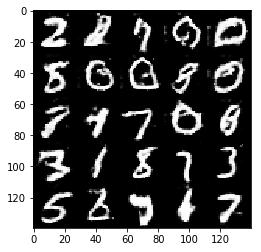

Epoch 2/2... Discriminator Loss: 0.5685... Generator Loss: 2.3208
Epoch 2/2... Discriminator Loss: 0.7272... Generator Loss: 1.3395
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 1.6729
Epoch 2/2... Discriminator Loss: 1.1499... Generator Loss: 0.7195
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 1.6078
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 0.9261
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.5881
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 1.7523


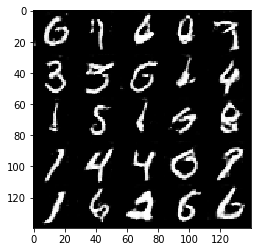

Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 2.1451
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 1.4497
Epoch 2/2... Discriminator Loss: 0.7099... Generator Loss: 1.3716
Epoch 2/2... Discriminator Loss: 0.6507... Generator Loss: 1.6228
Epoch 2/2... Discriminator Loss: 0.4469... Generator Loss: 2.4921


In [39]:
#https://arxiv.org/pdf/1511.06434.pdf
# "All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02."
batch_size = 32
z_dim = 100
learning_rate = 0.0002
#"suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training."
beta1 = 0.5
#alpha = 0.15

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
                   mnist_dataset.shape, mnist_dataset.image_mode)

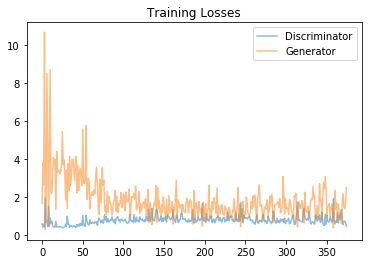

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 1.6295... Generator Loss: 0.4141
Epoch 1/10... Discriminator Loss: 0.6770... Generator Loss: 1.7401
Epoch 1/10... Discriminator Loss: 0.8998... Generator Loss: 1.5148
Epoch 1/10... Discriminator Loss: 0.6271... Generator Loss: 3.4085
Epoch 1/10... Discriminator Loss: 0.6209... Generator Loss: 2.5467
Epoch 1/10... Discriminator Loss: 0.9769... Generator Loss: 1.1755
Epoch 1/10... Discriminator Loss: 1.0934... Generator Loss: 0.8941
Epoch 1/10... Discriminator Loss: 0.7332... Generator Loss: 1.9709
Epoch 1/10... Discriminator Loss: 1.0117... Generator Loss: 0.9819
Epoch 1/10... Discriminator Loss: 0.6424... Generator Loss: 2.0378


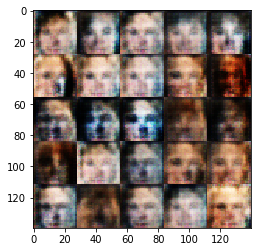

Epoch 1/10... Discriminator Loss: 0.8770... Generator Loss: 1.9097
Epoch 1/10... Discriminator Loss: 0.9663... Generator Loss: 1.9491
Epoch 1/10... Discriminator Loss: 1.1110... Generator Loss: 0.9274
Epoch 1/10... Discriminator Loss: 1.1226... Generator Loss: 0.9740
Epoch 1/10... Discriminator Loss: 1.0449... Generator Loss: 1.1437
Epoch 1/10... Discriminator Loss: 1.0366... Generator Loss: 1.1540
Epoch 1/10... Discriminator Loss: 1.2335... Generator Loss: 0.7195
Epoch 1/10... Discriminator Loss: 0.9805... Generator Loss: 2.5463
Epoch 1/10... Discriminator Loss: 1.0459... Generator Loss: 0.9187
Epoch 1/10... Discriminator Loss: 0.8987... Generator Loss: 1.6189


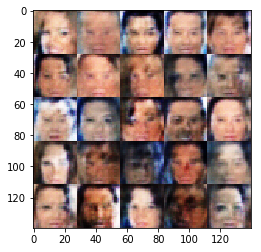

Epoch 1/10... Discriminator Loss: 1.0803... Generator Loss: 0.8125
Epoch 1/10... Discriminator Loss: 1.1204... Generator Loss: 1.0357
Epoch 1/10... Discriminator Loss: 1.0389... Generator Loss: 1.0761
Epoch 1/10... Discriminator Loss: 0.9070... Generator Loss: 1.0945
Epoch 1/10... Discriminator Loss: 1.3273... Generator Loss: 0.6246
Epoch 1/10... Discriminator Loss: 1.2278... Generator Loss: 0.6227
Epoch 1/10... Discriminator Loss: 1.0731... Generator Loss: 1.5203
Epoch 1/10... Discriminator Loss: 0.9838... Generator Loss: 1.0965
Epoch 1/10... Discriminator Loss: 0.8224... Generator Loss: 1.5241
Epoch 1/10... Discriminator Loss: 0.9429... Generator Loss: 1.3410


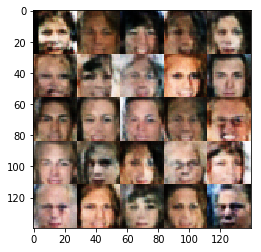

Epoch 1/10... Discriminator Loss: 1.2474... Generator Loss: 0.8466
Epoch 1/10... Discriminator Loss: 1.3039... Generator Loss: 0.6048
Epoch 1/10... Discriminator Loss: 1.0390... Generator Loss: 0.8629
Epoch 1/10... Discriminator Loss: 0.7770... Generator Loss: 1.9800
Epoch 1/10... Discriminator Loss: 1.0354... Generator Loss: 0.9125
Epoch 1/10... Discriminator Loss: 1.0157... Generator Loss: 1.1855
Epoch 1/10... Discriminator Loss: 0.9484... Generator Loss: 1.2331
Epoch 1/10... Discriminator Loss: 0.9788... Generator Loss: 1.1008
Epoch 1/10... Discriminator Loss: 1.0062... Generator Loss: 1.3187
Epoch 1/10... Discriminator Loss: 0.9304... Generator Loss: 1.4098


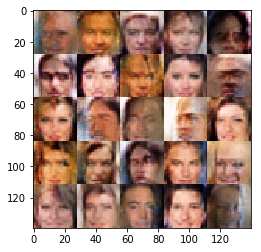

Epoch 1/10... Discriminator Loss: 1.0980... Generator Loss: 0.7836
Epoch 1/10... Discriminator Loss: 1.0429... Generator Loss: 0.9263
Epoch 1/10... Discriminator Loss: 1.1268... Generator Loss: 0.7894
Epoch 1/10... Discriminator Loss: 1.0897... Generator Loss: 0.9281
Epoch 1/10... Discriminator Loss: 0.8715... Generator Loss: 1.2628
Epoch 1/10... Discriminator Loss: 0.5486... Generator Loss: 2.6653
Epoch 1/10... Discriminator Loss: 1.0345... Generator Loss: 1.0995
Epoch 1/10... Discriminator Loss: 0.8852... Generator Loss: 1.1976
Epoch 1/10... Discriminator Loss: 0.9439... Generator Loss: 1.1632
Epoch 1/10... Discriminator Loss: 1.0419... Generator Loss: 1.0993


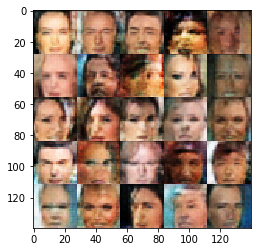

Epoch 1/10... Discriminator Loss: 1.0312... Generator Loss: 1.2201
Epoch 1/10... Discriminator Loss: 0.9118... Generator Loss: 1.1646
Epoch 1/10... Discriminator Loss: 0.9993... Generator Loss: 1.2596
Epoch 1/10... Discriminator Loss: 0.9200... Generator Loss: 1.0680
Epoch 1/10... Discriminator Loss: 1.0501... Generator Loss: 1.0333
Epoch 1/10... Discriminator Loss: 0.9089... Generator Loss: 1.0170
Epoch 1/10... Discriminator Loss: 0.9105... Generator Loss: 1.0305
Epoch 1/10... Discriminator Loss: 1.1661... Generator Loss: 0.7036
Epoch 1/10... Discriminator Loss: 0.9520... Generator Loss: 1.1777
Epoch 1/10... Discriminator Loss: 1.1512... Generator Loss: 0.7304


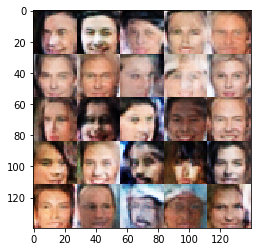

Epoch 1/10... Discriminator Loss: 1.2360... Generator Loss: 0.5877
Epoch 1/10... Discriminator Loss: 1.0630... Generator Loss: 0.8438
Epoch 1/10... Discriminator Loss: 1.3545... Generator Loss: 0.5108
Epoch 2/10... Discriminator Loss: 0.9729... Generator Loss: 1.1577
Epoch 2/10... Discriminator Loss: 1.2033... Generator Loss: 0.8273
Epoch 2/10... Discriminator Loss: 1.2482... Generator Loss: 0.6981
Epoch 2/10... Discriminator Loss: 0.8173... Generator Loss: 1.3551
Epoch 2/10... Discriminator Loss: 1.0507... Generator Loss: 0.8973
Epoch 2/10... Discriminator Loss: 1.1222... Generator Loss: 1.0136
Epoch 2/10... Discriminator Loss: 1.0381... Generator Loss: 0.9078


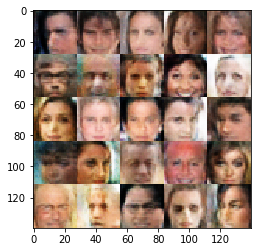

Epoch 2/10... Discriminator Loss: 0.9465... Generator Loss: 1.1594
Epoch 2/10... Discriminator Loss: 1.0231... Generator Loss: 1.1113
Epoch 2/10... Discriminator Loss: 1.1191... Generator Loss: 0.8695
Epoch 2/10... Discriminator Loss: 0.8846... Generator Loss: 1.1952
Epoch 2/10... Discriminator Loss: 1.0644... Generator Loss: 0.8052
Epoch 2/10... Discriminator Loss: 1.0689... Generator Loss: 0.8982
Epoch 2/10... Discriminator Loss: 1.0537... Generator Loss: 0.8684
Epoch 2/10... Discriminator Loss: 0.9149... Generator Loss: 1.1505
Epoch 2/10... Discriminator Loss: 0.8373... Generator Loss: 1.3394
Epoch 2/10... Discriminator Loss: 0.8520... Generator Loss: 1.3941


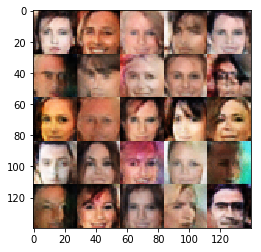

Epoch 2/10... Discriminator Loss: 1.0789... Generator Loss: 0.8556
Epoch 2/10... Discriminator Loss: 1.0346... Generator Loss: 0.9707
Epoch 2/10... Discriminator Loss: 1.1308... Generator Loss: 0.6838
Epoch 2/10... Discriminator Loss: 0.9646... Generator Loss: 1.0136
Epoch 2/10... Discriminator Loss: 1.0051... Generator Loss: 1.0504
Epoch 2/10... Discriminator Loss: 1.3214... Generator Loss: 0.6038
Epoch 2/10... Discriminator Loss: 1.0861... Generator Loss: 0.8453
Epoch 2/10... Discriminator Loss: 1.0127... Generator Loss: 0.9556
Epoch 2/10... Discriminator Loss: 1.0323... Generator Loss: 1.3331
Epoch 2/10... Discriminator Loss: 1.3536... Generator Loss: 0.5864


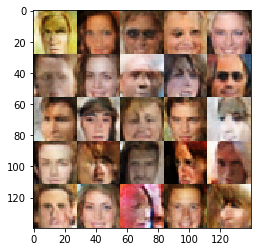

Epoch 2/10... Discriminator Loss: 1.2235... Generator Loss: 0.7815
Epoch 2/10... Discriminator Loss: 1.0171... Generator Loss: 0.8653
Epoch 2/10... Discriminator Loss: 1.0163... Generator Loss: 1.0053
Epoch 2/10... Discriminator Loss: 0.9990... Generator Loss: 1.3554
Epoch 2/10... Discriminator Loss: 1.2158... Generator Loss: 0.6605
Epoch 2/10... Discriminator Loss: 1.1966... Generator Loss: 0.7231
Epoch 2/10... Discriminator Loss: 1.0043... Generator Loss: 1.0853
Epoch 2/10... Discriminator Loss: 1.2276... Generator Loss: 0.7687
Epoch 2/10... Discriminator Loss: 1.0154... Generator Loss: 0.8596
Epoch 2/10... Discriminator Loss: 1.1283... Generator Loss: 0.7550


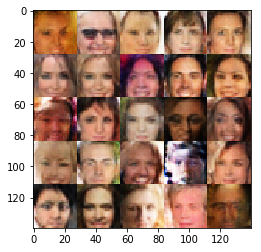

Epoch 2/10... Discriminator Loss: 1.0527... Generator Loss: 1.0586
Epoch 2/10... Discriminator Loss: 1.0776... Generator Loss: 0.9505
Epoch 2/10... Discriminator Loss: 0.9377... Generator Loss: 1.1932
Epoch 2/10... Discriminator Loss: 0.9345... Generator Loss: 1.0318
Epoch 2/10... Discriminator Loss: 0.9273... Generator Loss: 1.0785
Epoch 2/10... Discriminator Loss: 1.0812... Generator Loss: 0.8217
Epoch 2/10... Discriminator Loss: 1.0107... Generator Loss: 1.0114
Epoch 2/10... Discriminator Loss: 0.7041... Generator Loss: 1.7555
Epoch 2/10... Discriminator Loss: 0.8496... Generator Loss: 1.4933
Epoch 2/10... Discriminator Loss: 1.0424... Generator Loss: 1.0617


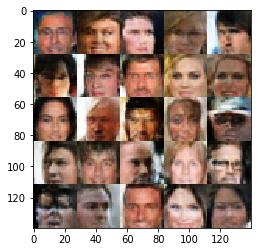

Epoch 2/10... Discriminator Loss: 1.1457... Generator Loss: 0.8662
Epoch 2/10... Discriminator Loss: 1.2910... Generator Loss: 1.1392
Epoch 2/10... Discriminator Loss: 0.9729... Generator Loss: 1.1709
Epoch 2/10... Discriminator Loss: 1.1498... Generator Loss: 0.8001
Epoch 2/10... Discriminator Loss: 0.9335... Generator Loss: 1.4762
Epoch 2/10... Discriminator Loss: 1.0826... Generator Loss: 0.9557
Epoch 2/10... Discriminator Loss: 1.0237... Generator Loss: 0.9596
Epoch 2/10... Discriminator Loss: 1.2556... Generator Loss: 0.7838
Epoch 2/10... Discriminator Loss: 1.1015... Generator Loss: 0.8979
Epoch 2/10... Discriminator Loss: 1.0403... Generator Loss: 0.8178


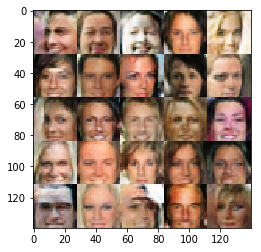

Epoch 2/10... Discriminator Loss: 1.0547... Generator Loss: 0.9766
Epoch 2/10... Discriminator Loss: 1.0164... Generator Loss: 0.8985
Epoch 2/10... Discriminator Loss: 1.2106... Generator Loss: 0.9416
Epoch 2/10... Discriminator Loss: 0.9220... Generator Loss: 1.4074
Epoch 2/10... Discriminator Loss: 1.0982... Generator Loss: 0.7888
Epoch 2/10... Discriminator Loss: 1.0257... Generator Loss: 0.9969
Epoch 3/10... Discriminator Loss: 1.0154... Generator Loss: 0.9603
Epoch 3/10... Discriminator Loss: 1.0667... Generator Loss: 0.7808
Epoch 3/10... Discriminator Loss: 1.3184... Generator Loss: 0.5416
Epoch 3/10... Discriminator Loss: 1.4125... Generator Loss: 0.5465


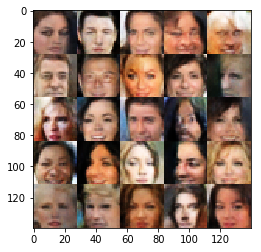

Epoch 3/10... Discriminator Loss: 1.3374... Generator Loss: 0.5503
Epoch 3/10... Discriminator Loss: 1.1170... Generator Loss: 0.9167
Epoch 3/10... Discriminator Loss: 0.9750... Generator Loss: 1.1825
Epoch 3/10... Discriminator Loss: 1.0165... Generator Loss: 0.9324
Epoch 3/10... Discriminator Loss: 1.1852... Generator Loss: 0.6850
Epoch 3/10... Discriminator Loss: 1.0598... Generator Loss: 0.7693
Epoch 3/10... Discriminator Loss: 1.2409... Generator Loss: 0.6595
Epoch 3/10... Discriminator Loss: 1.2543... Generator Loss: 1.4587
Epoch 3/10... Discriminator Loss: 1.2418... Generator Loss: 0.6082
Epoch 3/10... Discriminator Loss: 1.2691... Generator Loss: 0.6610


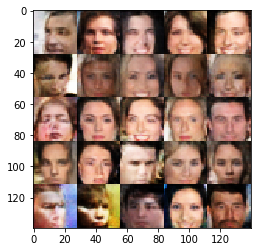

Epoch 3/10... Discriminator Loss: 0.9613... Generator Loss: 0.9268
Epoch 3/10... Discriminator Loss: 1.0628... Generator Loss: 0.8138
Epoch 3/10... Discriminator Loss: 0.9402... Generator Loss: 1.0549
Epoch 3/10... Discriminator Loss: 1.1468... Generator Loss: 0.6781
Epoch 3/10... Discriminator Loss: 0.8490... Generator Loss: 1.4807
Epoch 3/10... Discriminator Loss: 1.2224... Generator Loss: 0.6890
Epoch 3/10... Discriminator Loss: 0.9931... Generator Loss: 1.0242
Epoch 3/10... Discriminator Loss: 0.8482... Generator Loss: 1.1864
Epoch 3/10... Discriminator Loss: 1.0406... Generator Loss: 0.7788
Epoch 3/10... Discriminator Loss: 1.1961... Generator Loss: 0.6811


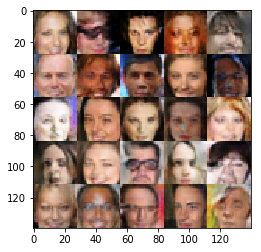

Epoch 3/10... Discriminator Loss: 1.1945... Generator Loss: 0.6732
Epoch 3/10... Discriminator Loss: 1.1584... Generator Loss: 0.9504
Epoch 3/10... Discriminator Loss: 1.1723... Generator Loss: 0.7238
Epoch 3/10... Discriminator Loss: 0.9523... Generator Loss: 1.1474
Epoch 3/10... Discriminator Loss: 0.9667... Generator Loss: 1.3512
Epoch 3/10... Discriminator Loss: 1.2730... Generator Loss: 0.8135
Epoch 3/10... Discriminator Loss: 1.1627... Generator Loss: 0.7343
Epoch 3/10... Discriminator Loss: 1.0454... Generator Loss: 1.1575
Epoch 3/10... Discriminator Loss: 1.3214... Generator Loss: 0.6372
Epoch 3/10... Discriminator Loss: 1.0051... Generator Loss: 0.9490


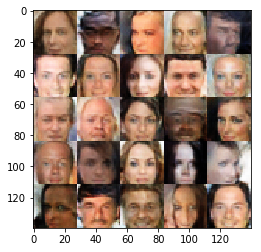

Epoch 3/10... Discriminator Loss: 1.0308... Generator Loss: 1.3686
Epoch 3/10... Discriminator Loss: 1.1681... Generator Loss: 0.8910
Epoch 3/10... Discriminator Loss: 1.2662... Generator Loss: 0.6047
Epoch 3/10... Discriminator Loss: 1.0205... Generator Loss: 0.9788
Epoch 3/10... Discriminator Loss: 0.8473... Generator Loss: 1.8752
Epoch 3/10... Discriminator Loss: 1.1352... Generator Loss: 0.7287
Epoch 3/10... Discriminator Loss: 1.1534... Generator Loss: 0.7598
Epoch 3/10... Discriminator Loss: 1.2174... Generator Loss: 0.6912
Epoch 3/10... Discriminator Loss: 1.1847... Generator Loss: 0.6381
Epoch 3/10... Discriminator Loss: 0.8722... Generator Loss: 1.1914


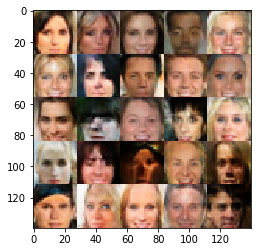

Epoch 3/10... Discriminator Loss: 0.8686... Generator Loss: 1.2781
Epoch 3/10... Discriminator Loss: 1.2100... Generator Loss: 0.6490
Epoch 3/10... Discriminator Loss: 1.3424... Generator Loss: 0.5880
Epoch 3/10... Discriminator Loss: 0.9059... Generator Loss: 1.3966
Epoch 3/10... Discriminator Loss: 1.1385... Generator Loss: 0.7203
Epoch 3/10... Discriminator Loss: 0.9624... Generator Loss: 1.0100
Epoch 3/10... Discriminator Loss: 0.9377... Generator Loss: 1.1149
Epoch 3/10... Discriminator Loss: 1.3778... Generator Loss: 0.5755
Epoch 3/10... Discriminator Loss: 1.0667... Generator Loss: 0.8052
Epoch 3/10... Discriminator Loss: 1.1279... Generator Loss: 0.8217


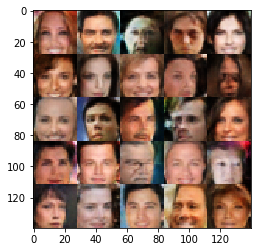

Epoch 3/10... Discriminator Loss: 1.2617... Generator Loss: 0.7095
Epoch 3/10... Discriminator Loss: 1.2537... Generator Loss: 0.6243
Epoch 3/10... Discriminator Loss: 1.3798... Generator Loss: 0.4928
Epoch 3/10... Discriminator Loss: 1.1904... Generator Loss: 0.7553
Epoch 3/10... Discriminator Loss: 1.1214... Generator Loss: 1.4173
Epoch 3/10... Discriminator Loss: 1.1124... Generator Loss: 0.7491
Epoch 3/10... Discriminator Loss: 0.9284... Generator Loss: 1.1481
Epoch 3/10... Discriminator Loss: 0.9773... Generator Loss: 1.1255
Epoch 3/10... Discriminator Loss: 0.8022... Generator Loss: 1.2964
Epoch 4/10... Discriminator Loss: 1.0208... Generator Loss: 0.9038


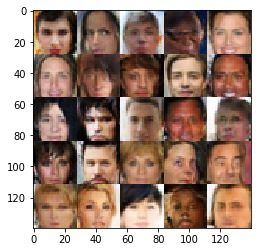

Epoch 4/10... Discriminator Loss: 1.3722... Generator Loss: 0.5380
Epoch 4/10... Discriminator Loss: 0.9716... Generator Loss: 1.0019
Epoch 4/10... Discriminator Loss: 0.8200... Generator Loss: 1.1769
Epoch 4/10... Discriminator Loss: 1.0275... Generator Loss: 1.3472
Epoch 4/10... Discriminator Loss: 1.2505... Generator Loss: 0.6022
Epoch 4/10... Discriminator Loss: 1.1690... Generator Loss: 1.1015
Epoch 4/10... Discriminator Loss: 0.9586... Generator Loss: 0.9914
Epoch 4/10... Discriminator Loss: 1.0504... Generator Loss: 0.8446
Epoch 4/10... Discriminator Loss: 1.0147... Generator Loss: 0.8873
Epoch 4/10... Discriminator Loss: 1.1782... Generator Loss: 0.7337


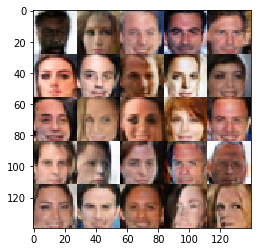

Epoch 4/10... Discriminator Loss: 1.1548... Generator Loss: 0.7480
Epoch 4/10... Discriminator Loss: 0.8731... Generator Loss: 1.4295
Epoch 4/10... Discriminator Loss: 1.2273... Generator Loss: 0.6445
Epoch 4/10... Discriminator Loss: 1.1778... Generator Loss: 0.6517
Epoch 4/10... Discriminator Loss: 1.2966... Generator Loss: 1.0259
Epoch 4/10... Discriminator Loss: 1.2212... Generator Loss: 1.4826
Epoch 4/10... Discriminator Loss: 1.0314... Generator Loss: 1.0462
Epoch 4/10... Discriminator Loss: 1.5989... Generator Loss: 0.3925
Epoch 4/10... Discriminator Loss: 1.2011... Generator Loss: 0.8035
Epoch 4/10... Discriminator Loss: 0.9337... Generator Loss: 0.9681


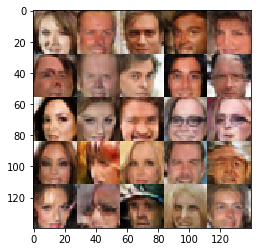

Epoch 4/10... Discriminator Loss: 1.3255... Generator Loss: 0.6177
Epoch 4/10... Discriminator Loss: 1.1545... Generator Loss: 0.8404
Epoch 4/10... Discriminator Loss: 0.8184... Generator Loss: 1.2191
Epoch 4/10... Discriminator Loss: 1.8187... Generator Loss: 0.3461
Epoch 4/10... Discriminator Loss: 0.6411... Generator Loss: 1.7486
Epoch 4/10... Discriminator Loss: 1.0855... Generator Loss: 0.9463
Epoch 4/10... Discriminator Loss: 1.3811... Generator Loss: 0.5194
Epoch 4/10... Discriminator Loss: 0.7302... Generator Loss: 1.3725
Epoch 4/10... Discriminator Loss: 0.7732... Generator Loss: 1.3718
Epoch 4/10... Discriminator Loss: 1.4615... Generator Loss: 0.4673


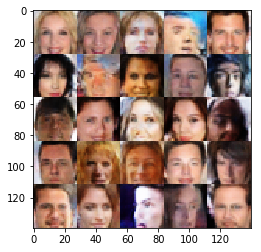

Epoch 4/10... Discriminator Loss: 1.1453... Generator Loss: 0.7041
Epoch 4/10... Discriminator Loss: 0.7540... Generator Loss: 1.4337
Epoch 4/10... Discriminator Loss: 1.0504... Generator Loss: 0.9350
Epoch 4/10... Discriminator Loss: 0.9225... Generator Loss: 0.9585
Epoch 4/10... Discriminator Loss: 1.2669... Generator Loss: 0.5941
Epoch 4/10... Discriminator Loss: 1.3423... Generator Loss: 0.5383
Epoch 4/10... Discriminator Loss: 1.0007... Generator Loss: 0.9365
Epoch 4/10... Discriminator Loss: 0.9135... Generator Loss: 1.1135
Epoch 4/10... Discriminator Loss: 0.8301... Generator Loss: 1.2280
Epoch 4/10... Discriminator Loss: 1.0110... Generator Loss: 1.0013


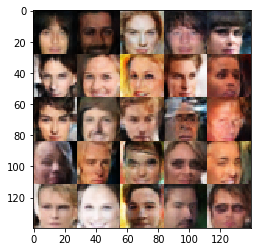

Epoch 4/10... Discriminator Loss: 0.7671... Generator Loss: 1.3308
Epoch 4/10... Discriminator Loss: 1.0839... Generator Loss: 1.1619
Epoch 4/10... Discriminator Loss: 0.9663... Generator Loss: 0.9043
Epoch 4/10... Discriminator Loss: 0.9023... Generator Loss: 1.3730
Epoch 4/10... Discriminator Loss: 1.0187... Generator Loss: 1.0039
Epoch 4/10... Discriminator Loss: 1.2261... Generator Loss: 0.7291
Epoch 4/10... Discriminator Loss: 0.9869... Generator Loss: 0.9598
Epoch 4/10... Discriminator Loss: 1.0999... Generator Loss: 0.7527
Epoch 4/10... Discriminator Loss: 1.1125... Generator Loss: 0.9248
Epoch 4/10... Discriminator Loss: 0.9299... Generator Loss: 1.0071


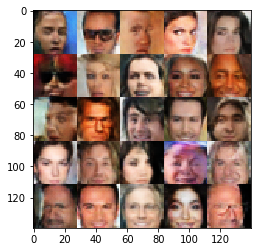

Epoch 4/10... Discriminator Loss: 1.0242... Generator Loss: 1.4447
Epoch 4/10... Discriminator Loss: 1.1981... Generator Loss: 0.6567
Epoch 4/10... Discriminator Loss: 1.2176... Generator Loss: 0.6840
Epoch 4/10... Discriminator Loss: 1.1182... Generator Loss: 0.7126
Epoch 4/10... Discriminator Loss: 1.6665... Generator Loss: 0.3398
Epoch 4/10... Discriminator Loss: 1.3603... Generator Loss: 0.5139
Epoch 4/10... Discriminator Loss: 0.8358... Generator Loss: 1.3749
Epoch 4/10... Discriminator Loss: 0.8501... Generator Loss: 1.2628
Epoch 4/10... Discriminator Loss: 1.1460... Generator Loss: 0.7103
Epoch 4/10... Discriminator Loss: 1.1998... Generator Loss: 0.6604


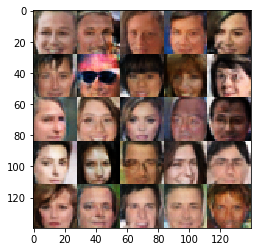

Epoch 4/10... Discriminator Loss: 0.9163... Generator Loss: 1.3535
Epoch 4/10... Discriminator Loss: 1.2598... Generator Loss: 0.6475
Epoch 4/10... Discriminator Loss: 0.8289... Generator Loss: 1.5982
Epoch 5/10... Discriminator Loss: 1.2515... Generator Loss: 0.5870
Epoch 5/10... Discriminator Loss: 1.1171... Generator Loss: 0.7860
Epoch 5/10... Discriminator Loss: 1.2550... Generator Loss: 0.6436
Epoch 5/10... Discriminator Loss: 0.8581... Generator Loss: 1.2314
Epoch 5/10... Discriminator Loss: 1.1456... Generator Loss: 0.7585
Epoch 5/10... Discriminator Loss: 0.7149... Generator Loss: 1.3506
Epoch 5/10... Discriminator Loss: 1.3547... Generator Loss: 0.5611


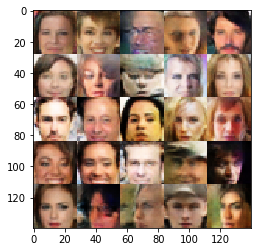

Epoch 5/10... Discriminator Loss: 1.1963... Generator Loss: 0.6363
Epoch 5/10... Discriminator Loss: 1.3988... Generator Loss: 1.1292
Epoch 5/10... Discriminator Loss: 0.8589... Generator Loss: 1.1107
Epoch 5/10... Discriminator Loss: 0.9101... Generator Loss: 1.3361
Epoch 5/10... Discriminator Loss: 1.1722... Generator Loss: 1.5422
Epoch 5/10... Discriminator Loss: 0.9582... Generator Loss: 1.0673
Epoch 5/10... Discriminator Loss: 0.7501... Generator Loss: 1.7544
Epoch 5/10... Discriminator Loss: 1.1758... Generator Loss: 0.6822
Epoch 5/10... Discriminator Loss: 0.9986... Generator Loss: 1.0494
Epoch 5/10... Discriminator Loss: 0.9995... Generator Loss: 0.9776


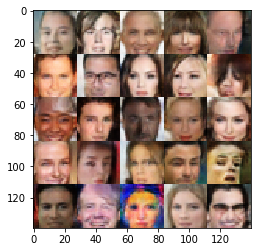

Epoch 5/10... Discriminator Loss: 0.6854... Generator Loss: 1.5743
Epoch 5/10... Discriminator Loss: 1.0702... Generator Loss: 0.7499
Epoch 5/10... Discriminator Loss: 0.9680... Generator Loss: 0.9974
Epoch 5/10... Discriminator Loss: 0.9554... Generator Loss: 1.1024
Epoch 5/10... Discriminator Loss: 0.8344... Generator Loss: 1.5199
Epoch 5/10... Discriminator Loss: 0.7903... Generator Loss: 1.2756
Epoch 5/10... Discriminator Loss: 1.1966... Generator Loss: 0.8340
Epoch 5/10... Discriminator Loss: 1.3153... Generator Loss: 0.5780
Epoch 5/10... Discriminator Loss: 0.7555... Generator Loss: 1.7308
Epoch 5/10... Discriminator Loss: 0.9246... Generator Loss: 0.9608


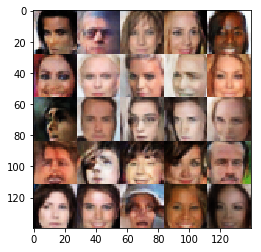

Epoch 5/10... Discriminator Loss: 0.8986... Generator Loss: 1.1911
Epoch 5/10... Discriminator Loss: 1.2593... Generator Loss: 0.6184
Epoch 5/10... Discriminator Loss: 1.1758... Generator Loss: 0.6531
Epoch 5/10... Discriminator Loss: 1.1184... Generator Loss: 0.7514
Epoch 5/10... Discriminator Loss: 0.8399... Generator Loss: 1.1700
Epoch 5/10... Discriminator Loss: 1.1926... Generator Loss: 0.8878
Epoch 5/10... Discriminator Loss: 0.8474... Generator Loss: 1.1767
Epoch 5/10... Discriminator Loss: 0.7250... Generator Loss: 1.2782
Epoch 5/10... Discriminator Loss: 0.6726... Generator Loss: 1.7527
Epoch 5/10... Discriminator Loss: 1.3189... Generator Loss: 0.5413


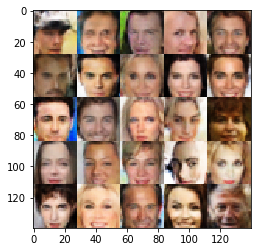

Epoch 5/10... Discriminator Loss: 1.0625... Generator Loss: 0.7655
Epoch 5/10... Discriminator Loss: 1.1494... Generator Loss: 0.7481
Epoch 5/10... Discriminator Loss: 0.6543... Generator Loss: 1.9724
Epoch 5/10... Discriminator Loss: 0.8228... Generator Loss: 1.6843
Epoch 5/10... Discriminator Loss: 1.0484... Generator Loss: 0.8922
Epoch 5/10... Discriminator Loss: 0.6945... Generator Loss: 1.5084
Epoch 5/10... Discriminator Loss: 1.0650... Generator Loss: 0.8964
Epoch 5/10... Discriminator Loss: 0.9509... Generator Loss: 0.9101
Epoch 5/10... Discriminator Loss: 0.7394... Generator Loss: 1.3502
Epoch 5/10... Discriminator Loss: 1.1076... Generator Loss: 1.9325


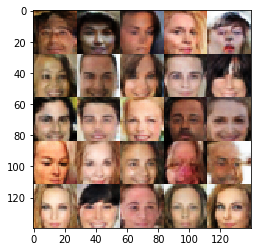

Epoch 5/10... Discriminator Loss: 1.2424... Generator Loss: 0.5998
Epoch 5/10... Discriminator Loss: 1.0061... Generator Loss: 1.0413
Epoch 5/10... Discriminator Loss: 0.7719... Generator Loss: 1.2306
Epoch 5/10... Discriminator Loss: 0.8901... Generator Loss: 1.1524
Epoch 5/10... Discriminator Loss: 1.0616... Generator Loss: 0.7165
Epoch 5/10... Discriminator Loss: 1.0573... Generator Loss: 0.7958
Epoch 5/10... Discriminator Loss: 1.2112... Generator Loss: 1.2463
Epoch 5/10... Discriminator Loss: 0.8707... Generator Loss: 1.1754
Epoch 5/10... Discriminator Loss: 0.9847... Generator Loss: 1.0884
Epoch 5/10... Discriminator Loss: 0.9106... Generator Loss: 1.3664


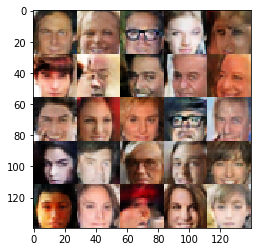

Epoch 5/10... Discriminator Loss: 0.9224... Generator Loss: 1.0055
Epoch 5/10... Discriminator Loss: 1.3575... Generator Loss: 0.6089
Epoch 5/10... Discriminator Loss: 0.9092... Generator Loss: 1.1864
Epoch 5/10... Discriminator Loss: 0.9514... Generator Loss: 0.9058
Epoch 5/10... Discriminator Loss: 0.9526... Generator Loss: 0.9717
Epoch 5/10... Discriminator Loss: 1.4033... Generator Loss: 0.4884
Epoch 6/10... Discriminator Loss: 1.2863... Generator Loss: 0.6095
Epoch 6/10... Discriminator Loss: 0.7233... Generator Loss: 1.3947
Epoch 6/10... Discriminator Loss: 0.8104... Generator Loss: 1.0977
Epoch 6/10... Discriminator Loss: 1.4486... Generator Loss: 0.5317


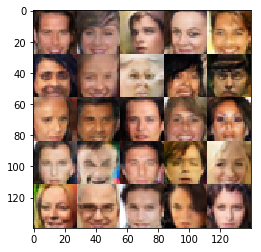

Epoch 6/10... Discriminator Loss: 1.0066... Generator Loss: 0.8014
Epoch 6/10... Discriminator Loss: 1.0183... Generator Loss: 1.1660
Epoch 6/10... Discriminator Loss: 0.7623... Generator Loss: 1.2454
Epoch 6/10... Discriminator Loss: 0.7752... Generator Loss: 1.2843
Epoch 6/10... Discriminator Loss: 0.7699... Generator Loss: 1.3084
Epoch 6/10... Discriminator Loss: 0.7499... Generator Loss: 1.4486
Epoch 6/10... Discriminator Loss: 1.1433... Generator Loss: 0.7403
Epoch 6/10... Discriminator Loss: 0.7301... Generator Loss: 1.5230
Epoch 6/10... Discriminator Loss: 1.3862... Generator Loss: 0.5632
Epoch 6/10... Discriminator Loss: 1.0685... Generator Loss: 0.8210


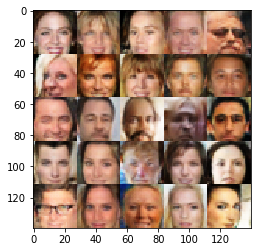

Epoch 6/10... Discriminator Loss: 1.0520... Generator Loss: 0.8263
Epoch 6/10... Discriminator Loss: 0.9579... Generator Loss: 0.9759
Epoch 6/10... Discriminator Loss: 1.0555... Generator Loss: 0.8432
Epoch 6/10... Discriminator Loss: 1.1394... Generator Loss: 0.8005
Epoch 6/10... Discriminator Loss: 0.9556... Generator Loss: 1.0090
Epoch 6/10... Discriminator Loss: 1.1385... Generator Loss: 0.7579
Epoch 6/10... Discriminator Loss: 1.0371... Generator Loss: 1.1186
Epoch 6/10... Discriminator Loss: 1.0041... Generator Loss: 1.5647
Epoch 6/10... Discriminator Loss: 0.9422... Generator Loss: 0.9123
Epoch 6/10... Discriminator Loss: 1.3701... Generator Loss: 0.5316


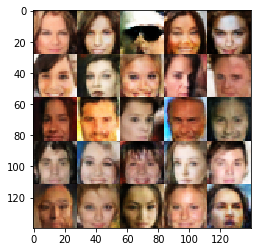

Epoch 6/10... Discriminator Loss: 0.8782... Generator Loss: 1.1872
Epoch 6/10... Discriminator Loss: 1.0621... Generator Loss: 1.1630
Epoch 6/10... Discriminator Loss: 1.4754... Generator Loss: 0.4837
Epoch 6/10... Discriminator Loss: 1.1580... Generator Loss: 0.8100
Epoch 6/10... Discriminator Loss: 1.0394... Generator Loss: 0.8183
Epoch 6/10... Discriminator Loss: 1.2875... Generator Loss: 0.5538
Epoch 6/10... Discriminator Loss: 0.6861... Generator Loss: 1.6418
Epoch 6/10... Discriminator Loss: 1.5940... Generator Loss: 0.4131
Epoch 6/10... Discriminator Loss: 1.2467... Generator Loss: 0.6370
Epoch 6/10... Discriminator Loss: 0.8026... Generator Loss: 1.2579


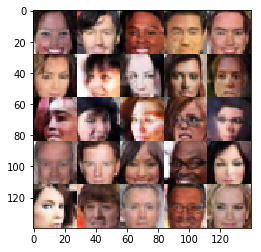

Epoch 6/10... Discriminator Loss: 1.0935... Generator Loss: 0.7698
Epoch 6/10... Discriminator Loss: 1.0332... Generator Loss: 1.1489
Epoch 6/10... Discriminator Loss: 1.0785... Generator Loss: 0.8820
Epoch 6/10... Discriminator Loss: 0.6161... Generator Loss: 2.1289
Epoch 6/10... Discriminator Loss: 1.1534... Generator Loss: 0.6728
Epoch 6/10... Discriminator Loss: 1.1448... Generator Loss: 0.7455
Epoch 6/10... Discriminator Loss: 1.5695... Generator Loss: 0.3911
Epoch 6/10... Discriminator Loss: 0.8362... Generator Loss: 1.1537
Epoch 6/10... Discriminator Loss: 1.4447... Generator Loss: 0.4670
Epoch 6/10... Discriminator Loss: 0.8713... Generator Loss: 1.2479


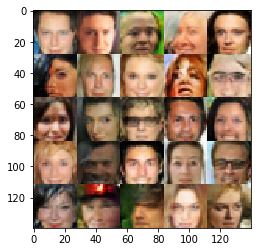

Epoch 6/10... Discriminator Loss: 1.2287... Generator Loss: 0.6508
Epoch 6/10... Discriminator Loss: 0.7234... Generator Loss: 1.4325
Epoch 6/10... Discriminator Loss: 1.4066... Generator Loss: 0.4934
Epoch 6/10... Discriminator Loss: 0.6727... Generator Loss: 2.1123
Epoch 6/10... Discriminator Loss: 0.6367... Generator Loss: 1.6340
Epoch 6/10... Discriminator Loss: 0.8584... Generator Loss: 1.2413
Epoch 6/10... Discriminator Loss: 1.0565... Generator Loss: 0.8715
Epoch 6/10... Discriminator Loss: 1.0525... Generator Loss: 1.6966
Epoch 6/10... Discriminator Loss: 1.2948... Generator Loss: 0.5661
Epoch 6/10... Discriminator Loss: 0.9895... Generator Loss: 0.9581


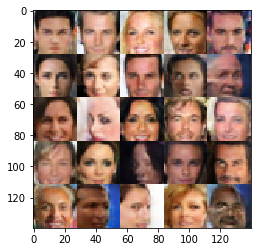

Epoch 6/10... Discriminator Loss: 0.9123... Generator Loss: 1.0790
Epoch 6/10... Discriminator Loss: 0.7932... Generator Loss: 1.7870
Epoch 6/10... Discriminator Loss: 1.0877... Generator Loss: 0.7510
Epoch 6/10... Discriminator Loss: 1.3024... Generator Loss: 0.5909
Epoch 6/10... Discriminator Loss: 0.9018... Generator Loss: 1.1628
Epoch 6/10... Discriminator Loss: 0.8815... Generator Loss: 1.2662
Epoch 6/10... Discriminator Loss: 1.4706... Generator Loss: 0.4715
Epoch 6/10... Discriminator Loss: 0.7643... Generator Loss: 1.3484
Epoch 6/10... Discriminator Loss: 1.0553... Generator Loss: 0.8260
Epoch 7/10... Discriminator Loss: 1.0762... Generator Loss: 0.7173


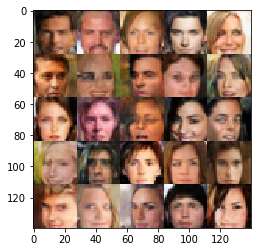

Epoch 7/10... Discriminator Loss: 0.6650... Generator Loss: 1.6794
Epoch 7/10... Discriminator Loss: 1.0371... Generator Loss: 0.8331
Epoch 7/10... Discriminator Loss: 0.9670... Generator Loss: 1.1225
Epoch 7/10... Discriminator Loss: 0.7168... Generator Loss: 1.6875
Epoch 7/10... Discriminator Loss: 0.6936... Generator Loss: 1.5326
Epoch 7/10... Discriminator Loss: 0.7961... Generator Loss: 1.2689
Epoch 7/10... Discriminator Loss: 1.2805... Generator Loss: 0.5488
Epoch 7/10... Discriminator Loss: 1.0507... Generator Loss: 0.7619
Epoch 7/10... Discriminator Loss: 1.1782... Generator Loss: 0.6654
Epoch 7/10... Discriminator Loss: 0.8953... Generator Loss: 1.0929


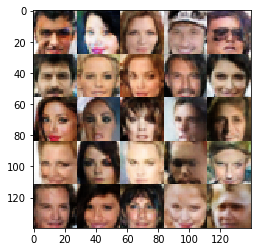

Epoch 7/10... Discriminator Loss: 1.2828... Generator Loss: 0.7212
Epoch 7/10... Discriminator Loss: 0.6973... Generator Loss: 1.4928
Epoch 7/10... Discriminator Loss: 0.6905... Generator Loss: 1.6457
Epoch 7/10... Discriminator Loss: 1.1647... Generator Loss: 0.6587
Epoch 7/10... Discriminator Loss: 1.2910... Generator Loss: 0.5794
Epoch 7/10... Discriminator Loss: 1.0594... Generator Loss: 0.7753
Epoch 7/10... Discriminator Loss: 1.0302... Generator Loss: 0.9283
Epoch 7/10... Discriminator Loss: 1.0820... Generator Loss: 0.9533
Epoch 7/10... Discriminator Loss: 0.8355... Generator Loss: 1.4455
Epoch 7/10... Discriminator Loss: 0.6588... Generator Loss: 1.6580


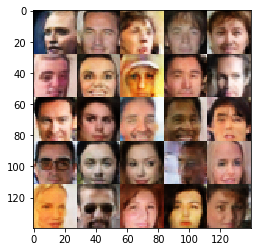

Epoch 7/10... Discriminator Loss: 0.7010... Generator Loss: 1.5210
Epoch 7/10... Discriminator Loss: 1.3394... Generator Loss: 0.5590
Epoch 7/10... Discriminator Loss: 1.0195... Generator Loss: 0.8230
Epoch 7/10... Discriminator Loss: 0.6998... Generator Loss: 1.6410
Epoch 7/10... Discriminator Loss: 1.0733... Generator Loss: 0.7861
Epoch 7/10... Discriminator Loss: 1.0275... Generator Loss: 0.9002
Epoch 7/10... Discriminator Loss: 0.7758... Generator Loss: 1.5589
Epoch 7/10... Discriminator Loss: 1.0421... Generator Loss: 0.7824
Epoch 7/10... Discriminator Loss: 0.7883... Generator Loss: 1.2525
Epoch 7/10... Discriminator Loss: 0.9761... Generator Loss: 1.0180


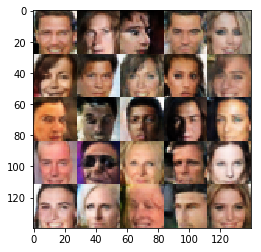

Epoch 7/10... Discriminator Loss: 1.0024... Generator Loss: 0.8322
Epoch 7/10... Discriminator Loss: 0.5261... Generator Loss: 2.0614
Epoch 7/10... Discriminator Loss: 1.1485... Generator Loss: 0.7466
Epoch 7/10... Discriminator Loss: 1.1798... Generator Loss: 0.6517
Epoch 7/10... Discriminator Loss: 1.2437... Generator Loss: 0.6507
Epoch 7/10... Discriminator Loss: 0.7073... Generator Loss: 1.4729
Epoch 7/10... Discriminator Loss: 1.1027... Generator Loss: 0.7694
Epoch 7/10... Discriminator Loss: 1.2021... Generator Loss: 0.7760
Epoch 7/10... Discriminator Loss: 1.1683... Generator Loss: 0.7271
Epoch 7/10... Discriminator Loss: 1.0358... Generator Loss: 0.8033


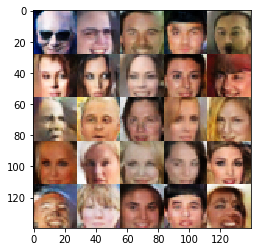

Epoch 7/10... Discriminator Loss: 1.1349... Generator Loss: 0.9318
Epoch 7/10... Discriminator Loss: 0.6627... Generator Loss: 1.8322
Epoch 7/10... Discriminator Loss: 0.7921... Generator Loss: 1.3061
Epoch 7/10... Discriminator Loss: 1.0665... Generator Loss: 0.7776
Epoch 7/10... Discriminator Loss: 1.3786... Generator Loss: 0.5009
Epoch 7/10... Discriminator Loss: 0.6524... Generator Loss: 1.9156
Epoch 7/10... Discriminator Loss: 0.8750... Generator Loss: 1.0263
Epoch 7/10... Discriminator Loss: 1.6828... Generator Loss: 0.3817
Epoch 7/10... Discriminator Loss: 0.9755... Generator Loss: 0.8855
Epoch 7/10... Discriminator Loss: 0.7457... Generator Loss: 1.2971


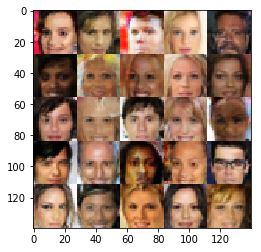

Epoch 7/10... Discriminator Loss: 0.9854... Generator Loss: 0.9113
Epoch 7/10... Discriminator Loss: 1.4453... Generator Loss: 0.5096
Epoch 7/10... Discriminator Loss: 0.9292... Generator Loss: 1.7344
Epoch 7/10... Discriminator Loss: 0.8741... Generator Loss: 1.0894
Epoch 7/10... Discriminator Loss: 1.0880... Generator Loss: 0.7765
Epoch 7/10... Discriminator Loss: 0.7593... Generator Loss: 1.2873
Epoch 7/10... Discriminator Loss: 1.7778... Generator Loss: 0.3194
Epoch 7/10... Discriminator Loss: 0.6805... Generator Loss: 1.5172
Epoch 7/10... Discriminator Loss: 0.7976... Generator Loss: 1.8089
Epoch 7/10... Discriminator Loss: 1.1919... Generator Loss: 0.6455


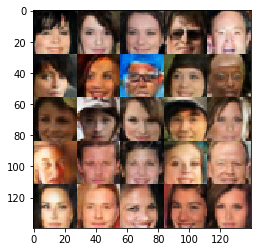

Epoch 7/10... Discriminator Loss: 0.8081... Generator Loss: 1.1548
Epoch 7/10... Discriminator Loss: 1.5661... Generator Loss: 0.4257
Epoch 7/10... Discriminator Loss: 1.0371... Generator Loss: 0.8462
Epoch 8/10... Discriminator Loss: 0.9459... Generator Loss: 1.1492
Epoch 8/10... Discriminator Loss: 1.3956... Generator Loss: 0.5119
Epoch 8/10... Discriminator Loss: 0.8653... Generator Loss: 1.1595
Epoch 8/10... Discriminator Loss: 0.8091... Generator Loss: 1.1934
Epoch 8/10... Discriminator Loss: 1.1749... Generator Loss: 0.6598
Epoch 8/10... Discriminator Loss: 0.7498... Generator Loss: 2.0666
Epoch 8/10... Discriminator Loss: 0.7576... Generator Loss: 1.3512


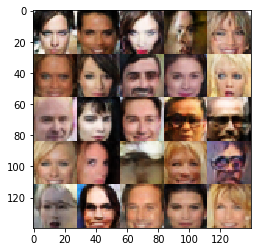

Epoch 8/10... Discriminator Loss: 0.7661... Generator Loss: 1.4717
Epoch 8/10... Discriminator Loss: 1.2736... Generator Loss: 0.6130
Epoch 8/10... Discriminator Loss: 0.9036... Generator Loss: 1.3481
Epoch 8/10... Discriminator Loss: 0.8607... Generator Loss: 1.0850
Epoch 8/10... Discriminator Loss: 0.9419... Generator Loss: 0.9566
Epoch 8/10... Discriminator Loss: 0.8759... Generator Loss: 1.1133
Epoch 8/10... Discriminator Loss: 1.6943... Generator Loss: 0.3942
Epoch 8/10... Discriminator Loss: 1.4811... Generator Loss: 0.4831
Epoch 8/10... Discriminator Loss: 0.6257... Generator Loss: 1.7152
Epoch 8/10... Discriminator Loss: 1.6549... Generator Loss: 0.3838


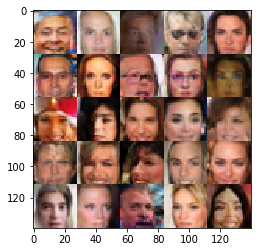

Epoch 8/10... Discriminator Loss: 0.7741... Generator Loss: 1.2521
Epoch 8/10... Discriminator Loss: 0.8882... Generator Loss: 2.3916
Epoch 8/10... Discriminator Loss: 0.9628... Generator Loss: 1.0071
Epoch 8/10... Discriminator Loss: 1.0766... Generator Loss: 0.7327
Epoch 8/10... Discriminator Loss: 0.6795... Generator Loss: 1.5663
Epoch 8/10... Discriminator Loss: 1.0397... Generator Loss: 0.9471
Epoch 8/10... Discriminator Loss: 1.2671... Generator Loss: 0.6855
Epoch 8/10... Discriminator Loss: 1.0324... Generator Loss: 0.8451
Epoch 8/10... Discriminator Loss: 0.7083... Generator Loss: 1.4116
Epoch 8/10... Discriminator Loss: 0.8903... Generator Loss: 1.1349


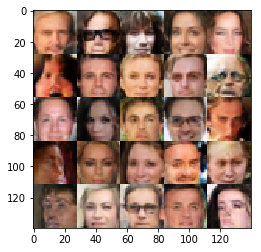

Epoch 8/10... Discriminator Loss: 0.7800... Generator Loss: 1.2922
Epoch 8/10... Discriminator Loss: 1.6052... Generator Loss: 0.4479
Epoch 8/10... Discriminator Loss: 0.7797... Generator Loss: 1.3703
Epoch 8/10... Discriminator Loss: 1.0436... Generator Loss: 1.3403
Epoch 8/10... Discriminator Loss: 0.9357... Generator Loss: 1.0373
Epoch 8/10... Discriminator Loss: 0.9332... Generator Loss: 0.9754
Epoch 8/10... Discriminator Loss: 1.3105... Generator Loss: 0.6012
Epoch 8/10... Discriminator Loss: 0.7804... Generator Loss: 1.4520
Epoch 8/10... Discriminator Loss: 0.9868... Generator Loss: 0.8586
Epoch 8/10... Discriminator Loss: 0.7154... Generator Loss: 1.5035


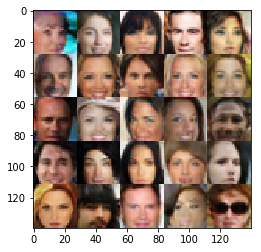

Epoch 8/10... Discriminator Loss: 1.0171... Generator Loss: 0.9099
Epoch 8/10... Discriminator Loss: 0.8036... Generator Loss: 1.1382
Epoch 8/10... Discriminator Loss: 0.9245... Generator Loss: 1.0512
Epoch 8/10... Discriminator Loss: 1.1637... Generator Loss: 0.7248
Epoch 8/10... Discriminator Loss: 1.4778... Generator Loss: 0.4876
Epoch 8/10... Discriminator Loss: 1.0132... Generator Loss: 0.8709
Epoch 8/10... Discriminator Loss: 1.2610... Generator Loss: 0.6184
Epoch 8/10... Discriminator Loss: 1.0309... Generator Loss: 0.9185
Epoch 8/10... Discriminator Loss: 0.4749... Generator Loss: 2.9154
Epoch 8/10... Discriminator Loss: 1.3383... Generator Loss: 0.8627


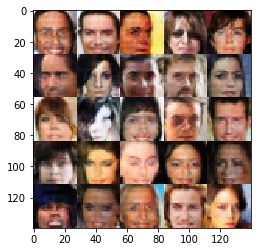

Epoch 8/10... Discriminator Loss: 0.9943... Generator Loss: 1.3627
Epoch 8/10... Discriminator Loss: 1.5997... Generator Loss: 0.6416
Epoch 8/10... Discriminator Loss: 1.3160... Generator Loss: 0.8465
Epoch 8/10... Discriminator Loss: 1.4900... Generator Loss: 0.6730
Epoch 8/10... Discriminator Loss: 1.2965... Generator Loss: 0.9647
Epoch 8/10... Discriminator Loss: 1.2172... Generator Loss: 1.1076
Epoch 8/10... Discriminator Loss: 1.4396... Generator Loss: 0.6892
Epoch 8/10... Discriminator Loss: 1.1682... Generator Loss: 1.0182
Epoch 8/10... Discriminator Loss: 1.3572... Generator Loss: 0.7642
Epoch 8/10... Discriminator Loss: 1.2237... Generator Loss: 1.0815


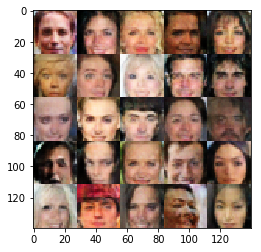

Epoch 8/10... Discriminator Loss: 1.1848... Generator Loss: 0.9883
Epoch 8/10... Discriminator Loss: 1.2342... Generator Loss: 0.9536
Epoch 8/10... Discriminator Loss: 1.3847... Generator Loss: 0.7644
Epoch 8/10... Discriminator Loss: 1.3277... Generator Loss: 0.7903
Epoch 8/10... Discriminator Loss: 1.3197... Generator Loss: 0.8550
Epoch 8/10... Discriminator Loss: 1.2332... Generator Loss: 0.9011
Epoch 9/10... Discriminator Loss: 1.1637... Generator Loss: 0.9912
Epoch 9/10... Discriminator Loss: 1.3041... Generator Loss: 0.9198
Epoch 9/10... Discriminator Loss: 1.3323... Generator Loss: 0.9306
Epoch 9/10... Discriminator Loss: 1.3265... Generator Loss: 0.9427


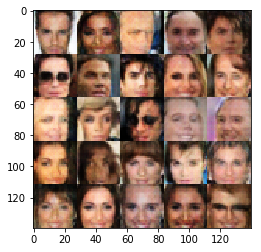

Epoch 9/10... Discriminator Loss: 1.3596... Generator Loss: 0.8229
Epoch 9/10... Discriminator Loss: 1.2725... Generator Loss: 0.9000
Epoch 9/10... Discriminator Loss: 1.4015... Generator Loss: 0.8039
Epoch 9/10... Discriminator Loss: 1.3934... Generator Loss: 0.8129
Epoch 9/10... Discriminator Loss: 1.3729... Generator Loss: 0.7846
Epoch 9/10... Discriminator Loss: 1.2802... Generator Loss: 0.8690
Epoch 9/10... Discriminator Loss: 1.3594... Generator Loss: 0.8064
Epoch 9/10... Discriminator Loss: 1.3824... Generator Loss: 0.8418
Epoch 9/10... Discriminator Loss: 1.3355... Generator Loss: 0.7672
Epoch 9/10... Discriminator Loss: 1.3774... Generator Loss: 0.8573


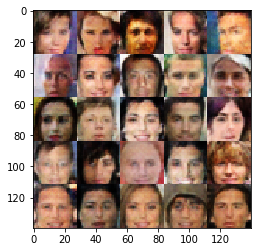

Epoch 9/10... Discriminator Loss: 1.4722... Generator Loss: 0.7411
Epoch 9/10... Discriminator Loss: 1.3402... Generator Loss: 0.8465
Epoch 9/10... Discriminator Loss: 1.4483... Generator Loss: 0.7293
Epoch 9/10... Discriminator Loss: 1.3029... Generator Loss: 0.8483
Epoch 9/10... Discriminator Loss: 1.5092... Generator Loss: 0.7173
Epoch 9/10... Discriminator Loss: 1.2740... Generator Loss: 0.8655
Epoch 9/10... Discriminator Loss: 1.4043... Generator Loss: 0.7789
Epoch 9/10... Discriminator Loss: 1.3515... Generator Loss: 0.8297
Epoch 9/10... Discriminator Loss: 1.4035... Generator Loss: 0.8219
Epoch 9/10... Discriminator Loss: 1.3909... Generator Loss: 0.8131


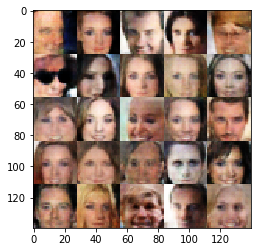

Epoch 9/10... Discriminator Loss: 1.3452... Generator Loss: 0.8449
Epoch 9/10... Discriminator Loss: 1.2891... Generator Loss: 0.8750
Epoch 9/10... Discriminator Loss: 1.3359... Generator Loss: 0.8460
Epoch 9/10... Discriminator Loss: 1.4267... Generator Loss: 0.7714
Epoch 9/10... Discriminator Loss: 1.3076... Generator Loss: 0.8642
Epoch 9/10... Discriminator Loss: 1.4733... Generator Loss: 0.6701
Epoch 9/10... Discriminator Loss: 1.2835... Generator Loss: 0.9368
Epoch 9/10... Discriminator Loss: 1.3959... Generator Loss: 0.7931
Epoch 9/10... Discriminator Loss: 1.4426... Generator Loss: 0.7172
Epoch 9/10... Discriminator Loss: 1.3096... Generator Loss: 0.8995


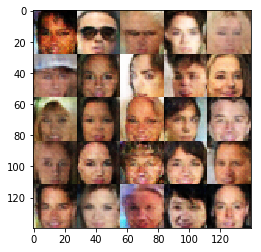

Epoch 9/10... Discriminator Loss: 1.3836... Generator Loss: 0.8461
Epoch 9/10... Discriminator Loss: 1.3795... Generator Loss: 0.7439
Epoch 9/10... Discriminator Loss: 1.2538... Generator Loss: 0.8749
Epoch 9/10... Discriminator Loss: 1.4044... Generator Loss: 0.7934
Epoch 9/10... Discriminator Loss: 1.3373... Generator Loss: 0.8538
Epoch 9/10... Discriminator Loss: 1.3912... Generator Loss: 0.7658
Epoch 9/10... Discriminator Loss: 1.3646... Generator Loss: 0.7844
Epoch 9/10... Discriminator Loss: 1.3848... Generator Loss: 0.8504
Epoch 9/10... Discriminator Loss: 1.3691... Generator Loss: 0.8280
Epoch 9/10... Discriminator Loss: 1.3441... Generator Loss: 0.8037


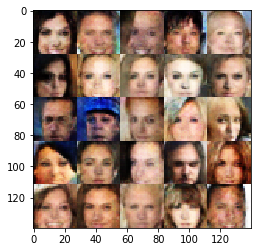

Epoch 9/10... Discriminator Loss: 1.4090... Generator Loss: 0.7574
Epoch 9/10... Discriminator Loss: 1.3571... Generator Loss: 0.8469
Epoch 9/10... Discriminator Loss: 1.3861... Generator Loss: 0.7689
Epoch 9/10... Discriminator Loss: 1.3113... Generator Loss: 0.8563
Epoch 9/10... Discriminator Loss: 1.4679... Generator Loss: 0.7729
Epoch 9/10... Discriminator Loss: 1.4017... Generator Loss: 0.7569
Epoch 9/10... Discriminator Loss: 1.3203... Generator Loss: 0.9451
Epoch 9/10... Discriminator Loss: 1.3318... Generator Loss: 0.8456
Epoch 9/10... Discriminator Loss: 1.4397... Generator Loss: 0.8249
Epoch 9/10... Discriminator Loss: 1.3747... Generator Loss: 0.7820


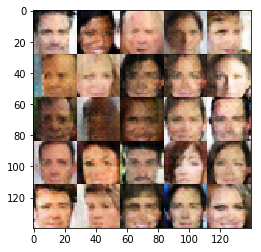

Epoch 9/10... Discriminator Loss: 1.3475... Generator Loss: 0.9403
Epoch 9/10... Discriminator Loss: 1.3060... Generator Loss: 0.8940
Epoch 9/10... Discriminator Loss: 1.3626... Generator Loss: 0.8952
Epoch 9/10... Discriminator Loss: 1.3793... Generator Loss: 0.7876
Epoch 9/10... Discriminator Loss: 1.2738... Generator Loss: 0.9211
Epoch 9/10... Discriminator Loss: 1.3545... Generator Loss: 0.7928
Epoch 9/10... Discriminator Loss: 1.3596... Generator Loss: 0.8159
Epoch 9/10... Discriminator Loss: 1.3280... Generator Loss: 0.8500
Epoch 9/10... Discriminator Loss: 1.3221... Generator Loss: 0.8685
Epoch 10/10... Discriminator Loss: 1.4037... Generator Loss: 0.7736


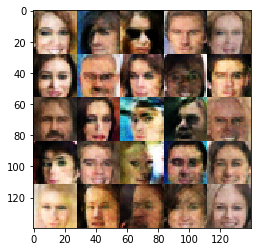

Epoch 10/10... Discriminator Loss: 1.4170... Generator Loss: 0.7974
Epoch 10/10... Discriminator Loss: 1.3497... Generator Loss: 0.9158
Epoch 10/10... Discriminator Loss: 1.4206... Generator Loss: 0.7102
Epoch 10/10... Discriminator Loss: 1.3874... Generator Loss: 0.7880
Epoch 10/10... Discriminator Loss: 1.3660... Generator Loss: 0.8246
Epoch 10/10... Discriminator Loss: 1.4219... Generator Loss: 0.8113
Epoch 10/10... Discriminator Loss: 1.3171... Generator Loss: 0.8307
Epoch 10/10... Discriminator Loss: 1.3828... Generator Loss: 0.7246
Epoch 10/10... Discriminator Loss: 1.3944... Generator Loss: 0.7803
Epoch 10/10... Discriminator Loss: 1.3765... Generator Loss: 0.8012


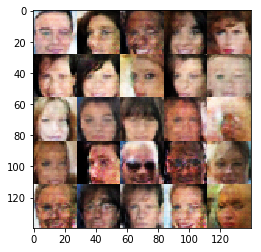

Epoch 10/10... Discriminator Loss: 1.4035... Generator Loss: 0.7335
Epoch 10/10... Discriminator Loss: 1.3868... Generator Loss: 0.8184
Epoch 10/10... Discriminator Loss: 1.4172... Generator Loss: 0.7983
Epoch 10/10... Discriminator Loss: 1.3840... Generator Loss: 0.7303
Epoch 10/10... Discriminator Loss: 1.4109... Generator Loss: 0.7953
Epoch 10/10... Discriminator Loss: 1.4102... Generator Loss: 0.8129
Epoch 10/10... Discriminator Loss: 1.3576... Generator Loss: 0.7938
Epoch 10/10... Discriminator Loss: 1.4040... Generator Loss: 0.6921
Epoch 10/10... Discriminator Loss: 1.3901... Generator Loss: 0.7910
Epoch 10/10... Discriminator Loss: 1.3603... Generator Loss: 0.8020


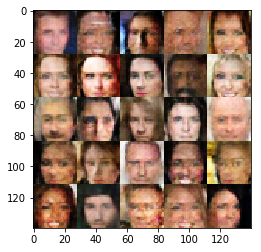

Epoch 10/10... Discriminator Loss: 1.3845... Generator Loss: 0.8238
Epoch 10/10... Discriminator Loss: 1.3926... Generator Loss: 0.7584
Epoch 10/10... Discriminator Loss: 1.3630... Generator Loss: 0.7732
Epoch 10/10... Discriminator Loss: 1.4175... Generator Loss: 0.8282
Epoch 10/10... Discriminator Loss: 1.3610... Generator Loss: 0.8306
Epoch 10/10... Discriminator Loss: 1.4660... Generator Loss: 0.8087
Epoch 10/10... Discriminator Loss: 1.3735... Generator Loss: 0.7426
Epoch 10/10... Discriminator Loss: 1.3098... Generator Loss: 0.8152
Epoch 10/10... Discriminator Loss: 1.3464... Generator Loss: 0.7813
Epoch 10/10... Discriminator Loss: 1.3541... Generator Loss: 0.8071


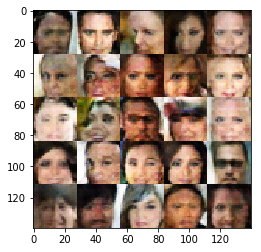

Epoch 10/10... Discriminator Loss: 1.3288... Generator Loss: 0.8366
Epoch 10/10... Discriminator Loss: 1.3261... Generator Loss: 0.8243
Epoch 10/10... Discriminator Loss: 1.4674... Generator Loss: 0.7463
Epoch 10/10... Discriminator Loss: 1.4489... Generator Loss: 0.7503
Epoch 10/10... Discriminator Loss: 1.3587... Generator Loss: 0.8223
Epoch 10/10... Discriminator Loss: 1.3810... Generator Loss: 0.8056
Epoch 10/10... Discriminator Loss: 1.4175... Generator Loss: 0.8053
Epoch 10/10... Discriminator Loss: 1.3825... Generator Loss: 0.7849
Epoch 10/10... Discriminator Loss: 1.3607... Generator Loss: 0.7553
Epoch 10/10... Discriminator Loss: 1.4635... Generator Loss: 0.7592


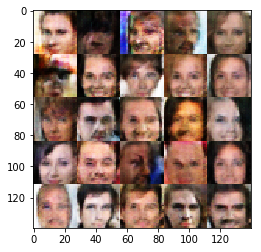

Epoch 10/10... Discriminator Loss: 1.4680... Generator Loss: 0.7910
Epoch 10/10... Discriminator Loss: 1.3892... Generator Loss: 0.7619
Epoch 10/10... Discriminator Loss: 1.3856... Generator Loss: 0.7901
Epoch 10/10... Discriminator Loss: 1.2893... Generator Loss: 0.8627
Epoch 10/10... Discriminator Loss: 1.4363... Generator Loss: 0.7393
Epoch 10/10... Discriminator Loss: 1.3714... Generator Loss: 0.7907
Epoch 10/10... Discriminator Loss: 1.4860... Generator Loss: 0.6634
Epoch 10/10... Discriminator Loss: 1.2857... Generator Loss: 0.8639
Epoch 10/10... Discriminator Loss: 1.3455... Generator Loss: 0.7868
Epoch 10/10... Discriminator Loss: 1.3453... Generator Loss: 0.8633


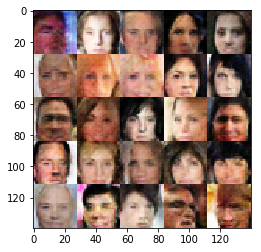

Epoch 10/10... Discriminator Loss: 1.4103... Generator Loss: 0.7807
Epoch 10/10... Discriminator Loss: 1.2984... Generator Loss: 0.8940
Epoch 10/10... Discriminator Loss: 1.4551... Generator Loss: 0.8195
Epoch 10/10... Discriminator Loss: 1.2751... Generator Loss: 0.8213
Epoch 10/10... Discriminator Loss: 1.3870... Generator Loss: 0.7280
Epoch 10/10... Discriminator Loss: 1.4253... Generator Loss: 0.7909
Epoch 10/10... Discriminator Loss: 1.3585... Generator Loss: 0.8108
Epoch 10/10... Discriminator Loss: 1.4276... Generator Loss: 0.7749
Epoch 10/10... Discriminator Loss: 1.3515... Generator Loss: 0.8735
Epoch 10/10... Discriminator Loss: 1.3427... Generator Loss: 0.8028


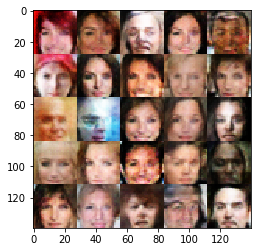

Epoch 10/10... Discriminator Loss: 1.4243... Generator Loss: 0.7471
Epoch 10/10... Discriminator Loss: 1.4584... Generator Loss: 0.7469
Epoch 10/10... Discriminator Loss: 1.3915... Generator Loss: 0.7181


In [44]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

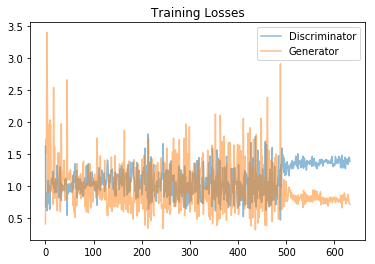

In [45]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

<html xmlns:o="urn:schemas-microsoft-com:office:office"
xmlns:x="urn:schemas-microsoft-com:office:excel"
xmlns="http://www.w3.org/TR/REC-html40">

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1252">
<meta name=ProgId content=Excel.Sheet>
<meta name=Generator content="Microsoft Excel 15">
<link rel=File-List
href="face%20generation%20hyper%20parameters_files/filelist.xml">
<style id="face generation hyper parameters_27150_Styles">
<!--table
	{mso-displayed-decimal-separator:"\.";
	mso-displayed-thousand-separator:"\,";}
.xl1527150
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:Calibri, sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:bottom;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:nowrap;}
.xl6327150
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:Calibri, sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:top;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:normal;
	mso-rotate:45;}
.xl6427150
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:Calibri, sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:bottom;
	background:#E7E6E6;
	mso-pattern:black none;
	white-space:nowrap;}
.xl6527150
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:Calibri, sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:bottom;
	background:yellow;
	mso-pattern:black none;
	white-space:nowrap;}
-->
</style>
</head>

<body>
<!--[if !excel]>&nbsp;&nbsp;<![endif]-->
<!--The following information was generated by Microsoft Excel's Publish as Web
Page wizard.-->
<!--If the same item is republished from Excel, all information between the DIV
tags will be replaced.-->
<!----------------------------->
<!--START OF OUTPUT FROM EXCEL PUBLISH AS WEB PAGE WIZARD -->
<!----------------------------->

<div id="face generation hyper parameters_27150" align=center
x:publishsource="Excel">

<table border=0 cellpadding=0 cellspacing=0 width=1003 style='border-collapse:
 collapse;table-layout:fixed;width:755pt'>
 <col width=64 style='width:48pt'>
 <col width=49 style='mso-width-source:userset;mso-width-alt:1792;width:37pt'>
 <col width=67 style='mso-width-source:userset;mso-width-alt:2450;width:50pt'>
 <col width=46 style='mso-width-source:userset;mso-width-alt:1682;width:35pt'>
 <col width=69 style='mso-width-source:userset;mso-width-alt:2523;width:52pt'>
 <col width=46 span=2 style='mso-width-source:userset;mso-width-alt:1682;
 width:35pt'>
 <col width=79 span=2 style='mso-width-source:userset;mso-width-alt:2889;
 width:59pt'>
 <col width=61 style='mso-width-source:userset;mso-width-alt:2230;width:46pt'>
 <col width=88 style='mso-width-source:userset;mso-width-alt:3218;width:66pt'>
 <col width=70 span=2 style='mso-width-source:userset;mso-width-alt:2560;
 width:53pt'>
 <col width=88 style='mso-width-source:userset;mso-width-alt:3218;width:66pt'>
 <col width=81 style='mso-width-source:userset;mso-width-alt:2962;width:61pt'>
 <tr height=60 style='height:45.0pt'>
  <td height=60 class=xl6327150 width=64 style='height:45.0pt;width:48pt'>Set</td>
  <td class=xl6327150 width=49 style='width:37pt'>Model<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl6327150 width=67 style='width:50pt'>Batch Size</td>
  <td class=xl6327150 width=46 style='width:35pt'>Z Dim</td>
  <td class=xl6327150 width=69 style='width:52pt'>Learning Rate</td>
  <td class=xl6327150 width=46 style='width:35pt'>Beta1</td>
  <td class=xl6327150 width=46 style='width:35pt'>Alpha</td>
  <td class=xl6327150 width=79 style='width:59pt'>Ending D_Loss</td>
  <td class=xl6327150 width=79 style='width:59pt'>Ending G_Loss</td>
  <td class=xl6327150 width=61 style='width:46pt'>Optimizer</td>
  <td class=xl6327150 width=88 style='width:66pt'>Extra gen execution</td>
  <td class=xl6327150 width=70 style='width:53pt'>Xavier Kern</td>
  <td class=xl6327150 width=70 style='width:53pt'>Smoothing</td>
  <td class=xl6327150 width=88 style='width:66pt'>Added Batch*=2</td>
  <td class=xl6327150 width=81 style='width:61pt'>Image Quality</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.206</td>
  <td class=xl1527150 align=right>2.2079</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>ok</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>B</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.1626</td>
  <td class=xl1527150 align=right>2.7554</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>ok</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>B</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0005</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.0656</td>
  <td class=xl1527150 align=right>3.7595</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>meh</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.2</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.4394</td>
  <td class=xl1527150 align=right>1.2432</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>ok</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>128</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.3473</td>
  <td class=xl1527150 align=right>1.699</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>poor</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>256</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.3548</td>
  <td class=xl1527150 align=right>2.2154</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>terrible</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.6728</td>
  <td class=xl1527150 align=right>1.0775</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>poor</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>200</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.5678</td>
  <td class=xl1527150 align=right>1.2664</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>good</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>200</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.7222</td>
  <td class=xl1527150 align=right>0.9603</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>better</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>200</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>1.8124</td>
  <td class=xl1527150 align=right>0.2573</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>better</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>CELEB</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>200</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>1.2216</td>
  <td class=xl1527150 align=right>0.7067</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>good</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>CELEB</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>200</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.7104</td>
  <td class=xl1527150 align=right>1.5574</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl6427150 colspan=2 style='height:15.0pt'>RESUBMISSION</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
  <td class=xl6427150>&nbsp;</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.35</td>
  <td class=xl1527150 align=right>0.09</td>
  <td class=xl1527150 align=right>0.6766</td>
  <td class=xl1527150 align=right>1.531</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>ok</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST<span
  style='mso-spacerun:yes'> </span></td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.35</td>
  <td class=xl1527150 align=right>0.09</td>
  <td class=xl1527150 align=right>0.8452</td>
  <td class=xl1527150 align=right>1.1002</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>poor</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.4</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.8154</td>
  <td class=xl1527150 align=right>1.346</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.85</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>ok</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.4</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>1.4437</td>
  <td class=xl1527150 align=right>0.5293</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150 align=right>1</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.85</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>worse</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.4</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>1.0491</td>
  <td class=xl1527150 align=right>0.9913</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150 align=right>1</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.85</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>poor</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>1.1769</td>
  <td class=xl1527150 align=right>0.6722</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>ok</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>Celeb</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>1.405</td>
  <td class=xl1527150 align=right>0.764</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>terrible</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>Celeb</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>200</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>terrible</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>A</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150><span style='mso-spacerun:yes'> </span></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150 align=right>0</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 colspan=6 style='height:15.0pt'>Added New Layer
  to both Discriminator and Generator</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>B</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>1.2184</td>
  <td class=xl1527150 align=right>0.4274</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150></td>
  <td class=xl1527150 align=right>0</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>ok</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>B</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.969</td>
  <td class=xl1527150 align=right>0.838</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150></td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>poor</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>B</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>1.1151</td>
  <td class=xl1527150 align=right>0.6976</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150 align=right>0.8</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>Bad</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>B</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.4697</td>
  <td class=xl1527150 align=right>2.1668</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>bad</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>B</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150 align=right>0.6593</td>
  <td class=xl1527150 align=right>1.9811</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150 align=right>0.8</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>better/bad</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 colspan=9 style='height:15.0pt'>Strengthen the
  Generator Layer -&gt; Add another fully connected layer to logits</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>C</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>terrible</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 colspan=5 style='height:15.0pt'>Weaken the
  Discriminator, take out a layer</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>D</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.1</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>terrible</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 colspan=8 style='height:15.0pt'>BACK to the
  original model which was performing better overall</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.2</td>
  <td class=xl1527150 align=right>0.4834</td>
  <td class=xl1527150 align=right>1.6078</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>good</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.7129</td>
  <td class=xl1527150 align=right>0.8714</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>previous slig<span style='display:none'>htly better</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.2</td>
  <td class=xl1527150 align=right>0.4212</td>
  <td class=xl1527150 align=right>1.5238</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>X</td>
  <td class=xl1527150 align=right>0.85</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>Slightly bett<span style='display:none'>er</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.4</td>
  <td class=xl1527150 align=right>0.2</td>
  <td class=xl1527150 align=right>0.4519</td>
  <td class=xl1527150 align=right>1.408</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.85</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>previous slig<span style='display:none'>htly better</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>1.324</td>
  <td class=xl1527150 align=right>0.4492</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>Not bad, bou<span style='display:none'>nces<span
  style='mso-spacerun:yes'> </span></span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.001</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.843</td>
  <td class=xl1527150 align=right>0.8527</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>worse</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.001</td>
  <td class=xl1527150 align=right>0.4</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.9376</td>
  <td class=xl1527150 align=right>0.7808</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>Still 37 best</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.001</td>
  <td class=xl1527150 align=right>0.4</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.4122</td>
  <td class=xl1527150 align=right>1.4615</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>Generator o<span style='display:none'>utput layer changed
  from 3 to 5</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.3592</td>
  <td class=xl1527150 align=right>1.5117</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>Not great</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.4609</td>
  <td class=xl1527150 align=right>1.2962</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>smooth fake <span style='display:none'>label</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.8716</td>
  <td class=xl1527150 align=right>1.1239</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.875</td>
  <td class=xl1527150>X</td>
  <td class=xl1527150>Adjusted Sm<span style='display:none'>oothing Calculation</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.7367</td>
  <td class=xl1527150 align=right>1.7308</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>Add dropout<span style='display:none'> to discriminator</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>64</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.8243</td>
  <td class=xl1527150 align=right>1.4014</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>suprisingly <span style='display:none'>worse</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.7493</td>
  <td class=xl1527150 align=right>1.251</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>dropout .85</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>dropout .5</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.000075</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.93941</td>
  <td class=xl1527150 align=right>0.9968</td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>dropout .7</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.001</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150 align=right>0.8877</td>
  <td class=xl1527150 align=right>1.1679</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>About the sa<span style='display:none'>me</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 colspan=8 style='height:15.0pt'>Take best and
  add another layer to both generator and discriminator</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>E</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>x</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>Much worse<span style='display:none'>…why? Don't
  understand</span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 colspan=7 style='height:15.0pt'>Removed
  additional layers from generator and discriminator</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>F</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0001</td>
  <td class=xl1527150 align=right>0.3</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 colspan=3 style='height:15.0pt'>Starting
  Over….Again…</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>G</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>rnd 0.02</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>Good</td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl6527150 style='height:15.0pt'>MNIST</td>
  <td class=xl1527150>G</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam<span style='mso-spacerun:yes'> </span></td>
  <td class=xl1527150></td>
  <td class=xl1527150>xavier</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>Xavier was p<span style='display:none'>oorer quality, but
  the losses chart looked to converge better.<span
  style='mso-spacerun:yes'> </span></span></td>
 </tr>
 <tr height=20 style='height:15.0pt'>
  <td height=20 class=xl1527150 style='height:15.0pt'>CELEBA</td>
  <td class=xl1527150>G</td>
  <td class=xl1527150 align=right>32</td>
  <td class=xl1527150 align=right>100</td>
  <td class=xl1527150 align=right>0.0002</td>
  <td class=xl1527150 align=right>0.5</td>
  <td class=xl1527150 align=right>0.15</td>
  <td class=xl1527150></td>
  <td class=xl1527150></td>
  <td class=xl1527150>Adam</td>
  <td class=xl1527150></td>
  <td class=xl1527150>xavier</td>
  <td class=xl1527150 align=right>0.9</td>
  <td class=xl1527150>x</td>
  <td class=xl1527150>It get's lost i<span style='display:none'>n the end</span></td>
 </tr>
 <![if supportMisalignedColumns]>
 <tr height=0 style='display:none'>
  <td width=64 style='width:48pt'></td>
  <td width=49 style='width:37pt'></td>
  <td width=67 style='width:50pt'></td>
  <td width=46 style='width:35pt'></td>
  <td width=69 style='width:52pt'></td>
  <td width=46 style='width:35pt'></td>
  <td width=46 style='width:35pt'></td>
  <td width=79 style='width:59pt'></td>
  <td width=79 style='width:59pt'></td>
  <td width=61 style='width:46pt'></td>
  <td width=88 style='width:66pt'></td>
  <td width=70 style='width:53pt'></td>
  <td width=70 style='width:53pt'></td>
  <td width=88 style='width:66pt'></td>
  <td width=81 style='width:61pt'></td>
 </tr>
 <![endif]>
</table>

</div>


<!----------------------------->
<!--END OF OUTPUT FROM EXCEL PUBLISH AS WEB PAGE WIZARD-->
<!----------------------------->
</body>

</html>
